### STEP : Taxonomic assignment
#### Taxonomic assignment with Silva 16S

Using Silva 16S classifier for Qiime2. List with all [classifiers](https://docs.qiime2.org/2020.6/data-resources/). 

#### Versions 
- [Silva 138 99% OTUs full-length sequences](https://data.qiime2.org/2020.6/common/silva-138-99-nb-classifier.qza)
- [Silva 138 99% OTUs from 515F/806R region of sequences](https://data.qiime2.org/2020.6/common/silva-138-99-515-806-nb-classifier.qza)
- [Greengenes 13_8 99% OTUs full-length sequences](https://data.qiime2.org/2020.6/common/gg-13-8-99-nb-classifier.qza)
- [Greengenes 13_8 99% OTUs from 515F/806R region of sequences](https://data.qiime2.org/2020.6/common/gg-13-8-99-515-806-nb-classifier.qza)

#### Methods
- [qiime feature-classifier](https://docs.qiime2.org/2022.2/plugins/available/feature-classifier/)
- [qiime feature-classifier classify-sklearn](https://docs.qiime2.org/2021.8/plugins/available/feature-classifier/classify-sklearn)
- [qiime metadata](https://docs.qiime2.org/2022.2/plugins/available/metadata/)
- [classify-hybrid-vsearch-sklearn](https://docs.qiime2.org/2022.2/plugins/available/feature-classifier/classify-hybrid-vsearch-sklearn/)
- [qiime metadata tabulate](https://docs.qiime2.org/2022.2/plugins/available/metadata/tabulate/)
- [qiime taxa](https://docs.qiime2.org/2022.2/plugins/available/taxa/)
- [qiime taxa barplot](https://docs.qiime2.org/2022.2/plugins/available/taxa/barplot/)

## Setup and settings

In [1]:
# Importing packages
import os
import pandas as pd
import numpy as np
from qiime2 import Artifact
from qiime2 import Visualization
from qiime2 import Metadata
import qiime2.plugins.metadata.actions as metadata_actions
from qiime2.plugins.metadata.visualizers import tabulate

from qiime2.plugins import feature_classifier
from qiime2.plugins import metadata
from qiime2.plugins import taxa

from qiime2.plugins.taxa.methods import collapse
from qiime2.plugins.taxa.methods import filter_table
from qiime2.plugins.feature_table.methods import filter_samples
from qiime2.plugins.feature_table.methods import filter_seqs
from qiime2.plugins.feature_table.visualizers import summarize
from qiime2.plugins.feature_table.methods import relative_frequency

import matplotlib.pyplot as plt
import seaborn as sns

from  statannot  import  add_stat_annotation

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_theme(style="ticks", palette="pastel")

In [2]:
# install scikit-learn specific version to use trained classifier
%pip install --user 'scikit-learn==0.23.1'

Note: you may need to restart the kernel to use updated packages.


### Receiving the parameters

The following cell can receive parameters using the [papermill](https://papermill.readthedocs.io/en/latest/) tool.

In [3]:
metadata_file = '/home/lauro/nupeb/rede-micro/redemicro-miliane-nutri/data/raw/metadata/miliane-metadata-CxAC.tsv'
base_dir = os.path.join('/', 'home', 'lauro', 'nupeb', 'rede-micro', 'redemicro-miliane-nutri')
experiment_name = 'miliane-CxAC-trim'
class_col = 'group-id'
replace_files = False
exclude_tax = False
top_n = None
classifier_file= None

In [4]:
# Parameters
experiment_name = "ana-flavia-NCxNR-trim"
base_dir = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri"
manifest_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/manifest/manifest-ana-flavia-NCxNR.csv"
metadata_file = "/home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/data/raw/metadata/metadata-ana-flavia-NCxNR.tsv"
class_col = "group-id"
classifier_file = "/home/lauro/nupeb/rede-micro/models/silva-138-99-nb-classifier.qza"
top_n = 20
replace_files = False
phred = 20
trunc_f = 0
trunc_r = 0
overlap = 12
threads = 6
trim = {
    "overlap": 8,
    "forward_primer": "CCTACGGGRSGCAGCAG",
    "reverse_primer": "GGACTACHVGGGTWTCTAAT",
}


In [5]:
experiment_folder = os.path.abspath(os.path.join(base_dir, 'experiments', experiment_name))
img_folder = os.path.abspath(os.path.join(experiment_folder, 'imgs'))
sheet_folder = os.path.abspath(os.path.join(experiment_folder, 'sheets'))
qiime_folder = os.path.join(experiment_folder, 'qiime-artifacts')

In [6]:
!mkdir -p {img_folder}
!mkdir -p {sheet_folder}
!mkdir -p {qiime_folder}

### Defining names, paths and flags

In [7]:
tax_level = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

In [8]:
# Input - DADA2 Artifacts
dada2_tabs_path = os.path.join(qiime_folder, 'dada2-tabs.qza')
dada2_reps_path = os.path.join(qiime_folder, 'dada2-reps.qza')
dada2_stat_path = os.path.join(qiime_folder, 'dada2-stat.qza')

# Input - Taxonomy Classifier - SILVA 138-99
classifier_path = classifier_file

# Output - Excel file
excel_path = os.path.join(sheet_folder, 'abundances.xlsx')

# Output - Metataxonomy Artifact
metatax_path = os.path.join(qiime_folder, 'metatax.qza')
metatax_view_path = os.path.join(qiime_folder, 'metatax.qzv')
metatax_bar_path = os.path.join(qiime_folder, 'metatax-bar.qzv')

# Flag - Load or create files
need_tax = not (os.path.isfile(metatax_path)) or replace_files
need_view = not (os.path.isfile(metatax_view_path) and os.path.isfile(metatax_bar_path)) or replace_files

## Step execution

### Load input files

This Step import the QIIME2 `SampleData[PairedEndSequencesWithQuality]` Artifact with all demultiplexed sequences and the `Metadata` file.

In [9]:
metadata_qa = Metadata.load(metadata_file)
metadata_df = metadata_qa.to_dataframe()
groups_values = list(metadata_qa.get_column(class_col).to_series().unique())
# tabulate(metadata_qa).visualization

In [10]:
alt_tab_path = os.path.join(base_dir, 'data', 'interim', 'dada2-tabs.qza')
# Verify if table file exists and if it is shared
if not os.path.isfile(dada2_tabs_path) and os.path.isfile(alt_tab_path):
    # If it is shared, create a local symbolic link
    os.symlink(alt_tab_path, dada2_tabs_path)
    
alt_rep_path = os.path.join(base_dir, 'data', 'interim', 'dada2-reps.qza')
# Verify if sequences file exists and if it is shared
if not os.path.isfile(dada2_reps_path) and os.path.isfile(alt_rep_path):
    # If it is shared, create a local symbolic link
    os.symlink(alt_rep_path, dada2_reps_path)

In [11]:
# Load FeatureData[Sequence] Artifact
reps = Artifact.load(dada2_reps_path)

# Load FeatureTable[Frequency] Artifact
tabs = Artifact.load(dada2_tabs_path)

In [12]:
# Filter FeatureTable[Frequency | RelativeFrequency | PresenceAbsence | Composition] based on Metadata sample ID values
tabs = filter_samples(
    table=tabs,
    metadata=metadata_qa,
).filtered_table
# Filter SampleData[SequencesWithQuality | PairedEndSequencesWithQuality | JoinedSequencesWithQuality] based on Metadata sample ID values; returns FeatureData[Sequence | AlignedSequence]
reps = filter_seqs(
    data=reps,
    table=tabs,
).filtered_data

In [13]:
asv_df = tabs.view(pd.DataFrame)

if not need_tax:
    
    # Load FeatureData[Taxonomy]
    metatax_qa = Artifact.load(metatax_path)
    
else:
    
    # Load TaxonomicClassifier Artifact
    classifier = Artifact.load(classifier_path)
    
    # Classify ASV features and create a new FeatureData[Taxonomy]
    metatax_qa = feature_classifier.methods.classify_sklearn(reads=reps, classifier=classifier, n_jobs=threads).classification

    # Save FeatureData[Taxonomy] Artifact
    metatax_qa.save(metatax_path)

metatax_df = metatax_qa.view(pd.DataFrame)

In [14]:
if not need_view:
    
    # Load Metatax
    metatax_qv = Visualization.load(metatax_view_path)
    metatax_bar_qv = Visualization.load(metatax_bar_path)
    
else:
    
    # Metataxonomy Table Visualization
    metatax_qv = metadata.visualizers.tabulate(metatax_qa.view(Metadata))
    metatax_qv.visualization.save(metatax_view_path)
    
    # Barplot Visualization
    # Next, we can view the taxonomic composition of our samples with interactive bar plots. 
    # Generate those plots with the following command and then open the visualization.
    metatax_bar_qv = taxa.visualizers.barplot(tabs, metatax_qa, metadata_qa)
    metatax_bar_qv.visualization.save(metatax_bar_path)

### Metataxonomy analysis

In [15]:
def filter_and_collapse(tab: Artifact, tax: Artifact, meta: Metadata, lvl: int, exclude: bool = True, exclude_list: str = 'uncultured,unidentified,metagenome,human') -> (Artifact, Visualization, pd.DataFrame):
    """ Filter and collapse the taxonomy table to the desired level and exclude the exclude_list from the taxonomy table

    :param tab: Artifact - qiime2 FeatureTable[Frequency] Artifact with the ASV table
    :param tax: Artifact - qiime2 FeatureData[Taxonomy] Artifact with the taxonomy classification
    :param meta: Metadata - qiime2 Metadata with the sample metadata
    :param lvl: int - 1 to 7
    :param exclude: bool - True to exclude the exclude_list from the taxonomy table
    :param exclude_list: str - comma separated list of strings to exclude from the taxonomy table
    :return: qiime2 FeatureTable[Frequency] Artifact, qiime2 Visualization, pandas DataFrame
    """

    to_include = ('d', 'p', 'c', 'o', 'f', 'g', 's')[lvl-1]
    to_include += '__'
    to_exclude = exclude_list if exclude else None
    
    if exclude:
        filtered_tabs = filter_table(
            table=tab, 
            taxonomy=tax,
            include=to_include,
            exclude=to_exclude,
            mode='contains').filtered_table
    else:
        filtered_tabs = tab
    
    collapsed_table: Artifact = collapse(table=filtered_tabs, taxonomy=tax, level=lvl).collapsed_table
    collapsed_table_view: Visualization = summarize(table=collapsed_table, sample_metadata=meta).visualization
    collapsed_table_df: pd.DataFrame = collapsed_table.view(pd.DataFrame)
    
    return collapsed_table, collapsed_table_view, collapsed_table_df


def get_keys_by_group(metadata_df: pd.DataFrame, asv_df: pd.DataFrame, group_id:str = 'group-id') -> dict:
    """ Get a dictionary with group-id as key and a list of sample-id as value
    Used to select samples from a group in an ASV dataframe
    :param metadata_df: metadata dataframe from qiime2 Metadata Artifact
    :param asv_df: ASV dataframe from qiime2 FeatureTable[Frequency] or FeatureTable[RelativeFrequency] Artifact
    :return: dictionary with group-id as key and a list of sample-id as value
    """
    groups_keys = dict()
    for i in metadata_df.groupby(group_id):
        groups_keys[i[0]] = asv_df.loc[i[1].index].index.tolist()
    return groups_keys

def expand_tax_cols(table_df: pd.DataFrame, metatax_df: pd.DataFrame, tax_col: str = 'Taxon') -> pd.DataFrame:
    """ Split the taxonomy column in the FeatureData[Taxonomy] Artifact and join with the FeatureTable[Frequency] or FeatureTable[RelativeFrequency] Artifact
     ASV table. Constructs a new dataframe with the abundance columns and the expanded taxonomy columns.

    :param table_df: pandas DataFrame - ASV table from qiime2 FeatureTable[Frequency] or FeatureTable[RelativeFrequency] Artifact
    :param metatax_df: pandas DataFrame - taxonomy dataframe from qiime2 FeatureData[Taxonomy] Artifact
    :param tax_col: str - name of the taxonomy column in the metatax_df dataframe (default: 'Taxon')
    :return: pandas DataFrame - new dataframe with the abundance columns and the expanded taxonomy columns
    """
    tax_df = metatax_df[tax_col].str.split(';', expand=True)
    new_df = table_df.T.join(metatax_df).join(tax_df)
    return new_df

def get_level_tax_df(table_df: pd.DataFrame, metatax_df: pd.DataFrame, level: int = 0, groups_keys: dict = None, round_by: int = 5, normalize: bool = False, filter_terms: list = None) -> pd.DataFrame:
    """ Get a new dataframe with the abundance columns and the expanded taxonomy columns grouped by the level and normalized by the total sum of the level group (default: 0) or the total sum of the dataframe (normalize=False).

    :param table_df: pandas DataFrame - ASV table from qiime2 FeatureTable[Frequency] or FeatureTable[RelativeFrequency] Artifact
    :param metatax_df: pandas DataFrame - taxonomy dataframe from qiime2 FeatureData[Taxonomy] Artifact
    :param level: int - 0 to 7 (default: 0)
    :param groups_keys: dict - dictionary with group-id as key and a list of sample-id as value (default: None)
    :param round_by: int - round the values by the number of decimals (default: 5)
    :param normalize: bool - normalize the values between 0 and 1 (default: False)
    :param filter_terms: list[str] - list of strings to filter the taxonomy dataframe (default: None)
    :return: pandas DataFrame - new dataframe with the abundance columns and the expanded taxonomy columns grouped by the level and normalized by the total sum of the level group (default: 0) or the total sum of the dataframe (normalize=False)
    """

    # expand the taxonomy columns and join the abundance columns from the ASV table (table_df) with the taxonomy table (metatax_df)
    expanded_df = expand_tax_cols(table_df, metatax_df, tax_col='Taxon')
    # fill the NaN values with '__unclassified'
    expanded_df.fillna('__unclassified', inplace=True)
    # group by the level and sum the abundance columns
    grouped_freqs_df = expanded_df.groupby(by=level, axis=0).sum()
    # remove the level prefix from the index strings
    grouped_freqs_df.index = [x.split('__')[1] if len(x.split('__'))>1 else 'unclassified' for x in grouped_freqs_df.index]
    # filter the dataframe by the filter_terms
    if filter_terms is not None:
        for tax in grouped_freqs_df.index:
            if len([x for x in filter_terms if x in tax]) > 0:
                grouped_freqs_df.drop(tax, axis=0, inplace=True)
    # create a new dataframe
    new_df = pd.DataFrame()
    # sum the columns of the new dataframe to get the total sum of the level group
    new_df['total_sum'] = grouped_freqs_df.sum(axis=1)
    # verify if groups_keys is not empty
    if groups_keys is not None:
        # iterate over the groups_keys (k = group-id, v = list of sample-id)
        for k, v in groups_keys.items():
            # sum the columns of the group samples and add the group column to the new_df dataframe
            new_df[f'{k}'] = grouped_freqs_df.loc[:, v].sum(axis=1)
    # concatenate the new_df dataframe with the grouped_freqs_df dataframe along the columns.
    new_df = pd.concat([new_df, grouped_freqs_df], axis=1)
    # sort the dataframe by the total sum column. The most abundant taxa will be on top
    new_df.sort_values(by='total_sum', ascending=False, inplace=True)
    # normalize the new_df dataframe. To relate the abundance of each taxon to the total abundance of the dataframe
    if normalize:
        new_df = (new_df / new_df.sum()).round(round_by)
    # return the dataframe
    return new_df

In [16]:
def get_df(tab, col_name, exclude=True):
    df = pd.DataFrame(tab.view(pd.DataFrame).sum(axis=0).sort_values(ascending=False), columns=[col_name])
    if exclude:
        new_index = [x.split(';')[-1][3:] for x in df.index]
        df.index = new_index
    return df

def get_samples_df(tab, exclude=True):
    df = tab.view(pd.DataFrame).T
    if exclude:
        new_index = [x.split(';')[-1][3:] for x in df.index]
        df.index = new_index
    return df

def create_rank_df(table, meta, groups, exclude=True, gid='group-id'):
    df = get_df(table, 'Total', exclude)
    for g in groups:
        query = f"[{gid}]='{g}'"
        group = filter_samples(table=table, metadata=meta, where=query, exclude_ids=False).filtered_table
        new_df = get_df(group, g, exclude)
        df = df.join(new_df, )
    df = df.fillna(0)
    return df        

def plot_rank(df, level_name, sort_by=None, top=None):
    if level_name == 'Kingdom':
        return
    print_top = True if type(top) in [int] else False
    print(sort_by)
    plt.figure()
    sns.set(rc={'figure.figsize':(12,4)})
    df = df.drop(['Total'], axis=1)
    if sort_by and sort_by in df.columns:
        df = df.sort_values(by=sort_by, ascending=False)
    if print_top:
        df = df.head(top)
    df.plot( kind='bar', stacked=True, )
    plt.ylabel('Abundances')
    plt.xlabel(level_name)
    msg = 'x'.join(df.columns)
    if print_top:
        plt.title(f'Top {top} {level_name} abundances rank for groups {msg} - Sorted by {sort_by}')
    else:
        plt.title(f'{level_name} abundances rank for groups {msg} - Sorted by {sort_by}')
    plt.tight_layout()
    if print_top:
        path = os.path.abspath(os.path.join(img_folder, f'abundance-rank-{level_name}-groups-{msg}-sorted-by-{sort_by}-top-{top}.svg'))
    else:
        path = os.path.abspath(os.path.join(img_folder, f'abundance-rank-{level_name}-groups-{msg}-sorted-by-{sort_by}.svg'))
    plt.tight_layout()
    plt.savefig(path, format='svg')
    plt.show()

In [17]:
def process_all_levels(tabs, metatax, metadata_qa, groups_values, experiment_name, to_exclude, gid='group-id', top=None):
    level_names = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    excel_name = f'abundance-ranks-{experiment_name}.xlsx'
    excel_path = os.path.abspath(os.path.join(sheet_folder, excel_name))
    with pd.ExcelWriter(excel_path, mode='w') as writer:
        opts = (True, False) if to_exclude else (False, )
        for exclude in opts:
            for i, lvl_name in enumerate(level_names):
                print(f'{i} - Processing {lvl_name} - Filtered {exclude}')

                collapsed_table, collapsed_table_view, collapsed_table_df = filter_and_collapse(
                    tabs, metatax, metadata_qa,
                    lvl=i+1,
                    exclude=exclude,
                    exclude_list='uncultured,unidentified,metagenome,human')

                rank_df = create_rank_df(collapsed_table, metadata_qa, groups=groups_values, exclude=exclude, gid=gid)
                samples_df = get_samples_df(collapsed_table, exclude)
                joined_df = rank_df.join(samples_df,)
                sheet_name = f"{lvl_name}{'-filtered' if exclude else ''}"
                joined_df.to_excel(writer, sheet_name=sheet_name)
                if exclude:
                    for g in ('total', *groups_values):
                        msg = f"{'Filtered-' if exclude else ''}{lvl_name}"
                        plot_rank(rank_df, level_name=lvl_name,sort_by=g)

In [18]:
def boxplot_rank(table, meta, tax, groups, lvl, exclude, gid='group-id', top=None):
    level_names = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']
    level_name = level_names[lvl-1]
    print_top = True if type(top) in [int] else False
    df = pd.DataFrame()
    collapsed_table, _, _ = filter_and_collapse(
        table, tax, meta, 
        lvl=lvl,
        exclude=exclude, 
        exclude_list='uncultured,unidentified,metagenome,human')
    collapsed_table_df = get_df(collapsed_table, col_name='Total')
    ordered_tax = collapsed_table_df.index
    for g in groups:
        print(f'Processing {level_name} - {g}')
        group = filter_samples(table=table, metadata=meta, where=f"[{gid}]='{g}'", exclude_ids=exclude).filtered_table
        collapsed_group, _, _ = filter_and_collapse(
            group, tax, meta, 
            lvl=lvl,
            exclude=exclude, 
            exclude_list='uncultured,unidentified,metagenome,human')
        collapsed_group_df = collapsed_group.view(pd.DataFrame)
        new_cols = [x.split(';')[-1][3:] for x in collapsed_group_df.columns]
        collapsed_group_df.columns = new_cols
        cols = [x for x in ordered_tax if x in new_cols]
        collapsed_group_df = collapsed_group_df[cols]
        collapsed_group_df['Group'] = g
        melted_df = collapsed_group_df.melt(value_name='Abundance', var_name='Taxonomy', id_vars='Group')
        df = pd.concat([df, melted_df], axis=0)
    # Select TOP N most abundant taxons
    if print_top:
        top_taxons = df.groupby('Taxonomy').sum().sort_values(by='Abundance', ascending=False).head(top_n).index.values.tolist()
        df = df[df['Taxonomy'].isin(top_taxons)]
    df['Abundance'] = np.log(df['Abundance']+1)
    plt.figure(figsize=(15,10))
    ax = sns.boxplot(x=df['Taxonomy'], y=df['Abundance'], hue=df['Group'])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(ylabel='log(# of reads)')
    if print_top:
        plt.title(f'Top {top} {level_name} abundances rank by groups.')
    else:
        plt.title(f'{level_name} abundances rank by groups.')
    plt.tight_layout()
    if print_top:
        path = os.path.abspath(os.path.join(img_folder, f'boxplot-abundance-rank-{level_name}-top-{top}.svg'))
    else:
        path = os.path.abspath(os.path.join(img_folder, f'boxplot-abundance-rank-{level_name}.svg'))
    plt.tight_layout()
    plt.savefig(path, format='svg')
    plt.show()

In [19]:
# species = filter_table(
#         table=tabs,
#         taxonomy=metatax_qa,).filtered_table
# species.view(pd.DataFrame)

In [20]:
process_all_levels(tabs, metatax_qa, metadata_qa, groups_values, experiment_name, to_exclude=exclude_tax, gid=class_col, top=top_n)

0 - Processing Kingdom - Filtered False


1 - Processing Phylum - Filtered False


2 - Processing Class - Filtered False


3 - Processing Order - Filtered False


4 - Processing Family - Filtered False


5 - Processing Genus - Filtered False


6 - Processing Species - Filtered False


Processing Kingdom - NC


Processing Kingdom - NR


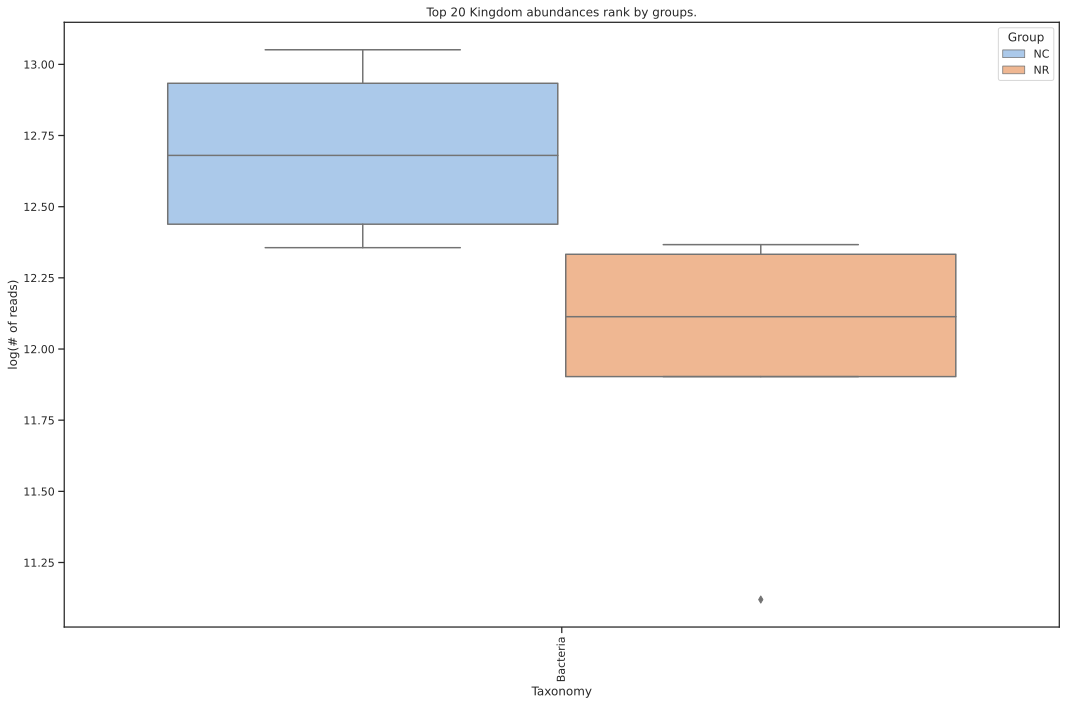

Processing Phylum - NC


Processing Phylum - NR


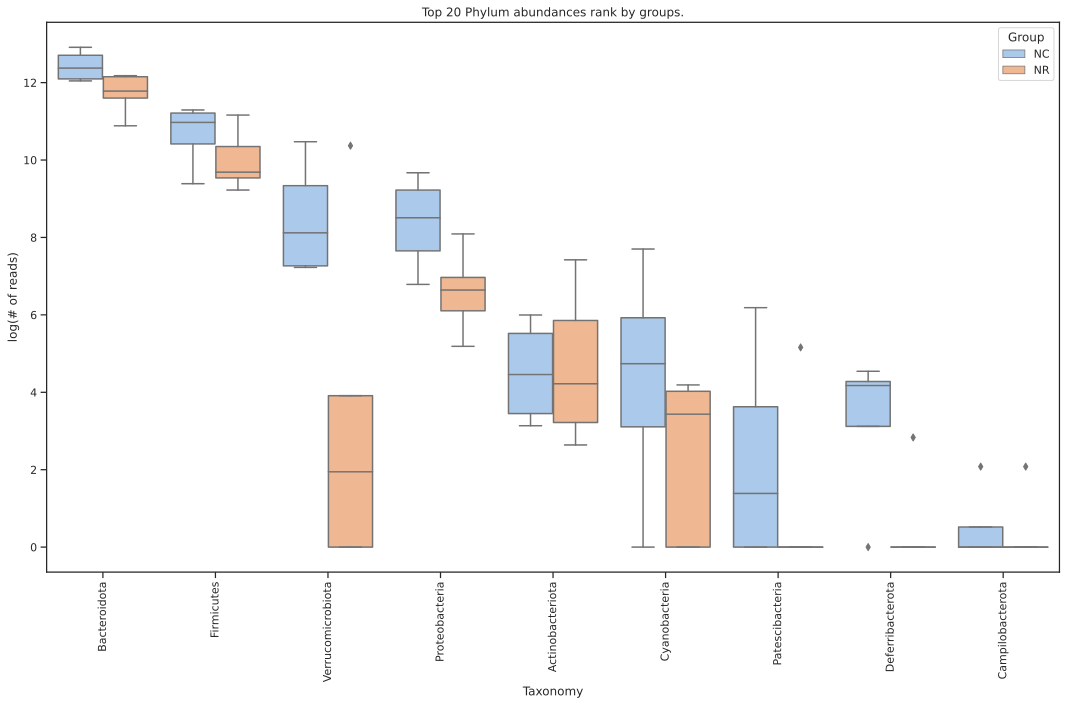

Processing Class - NC


Processing Class - NR


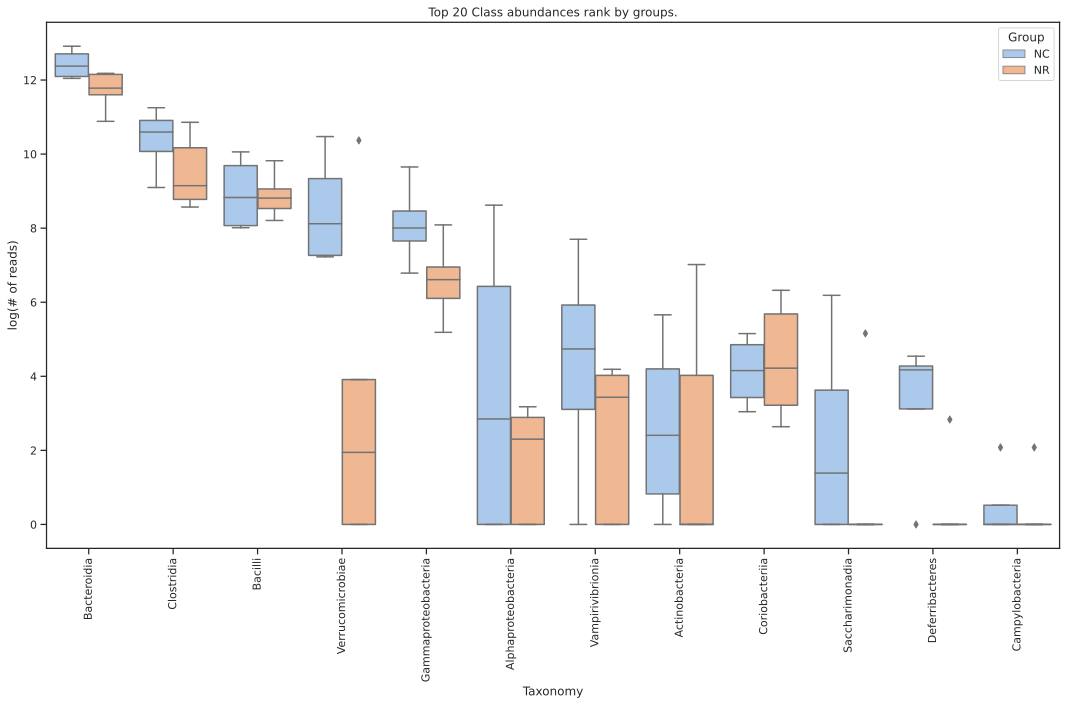

Processing Order - NC


Processing Order - NR


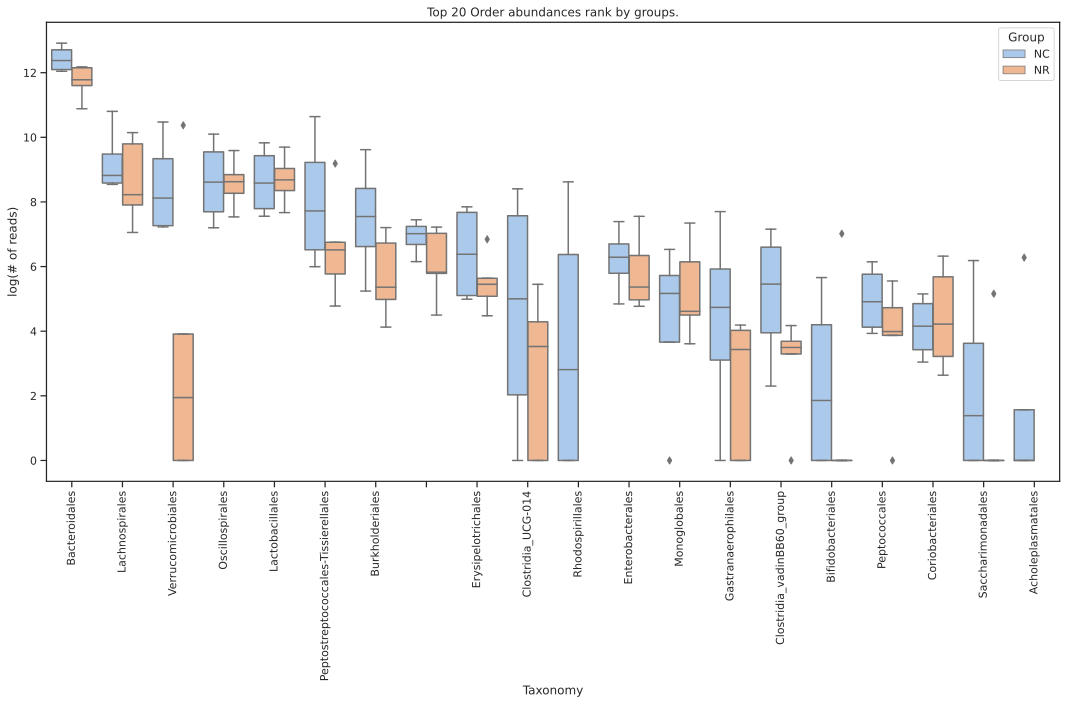

Processing Family - NC


Processing Family - NR


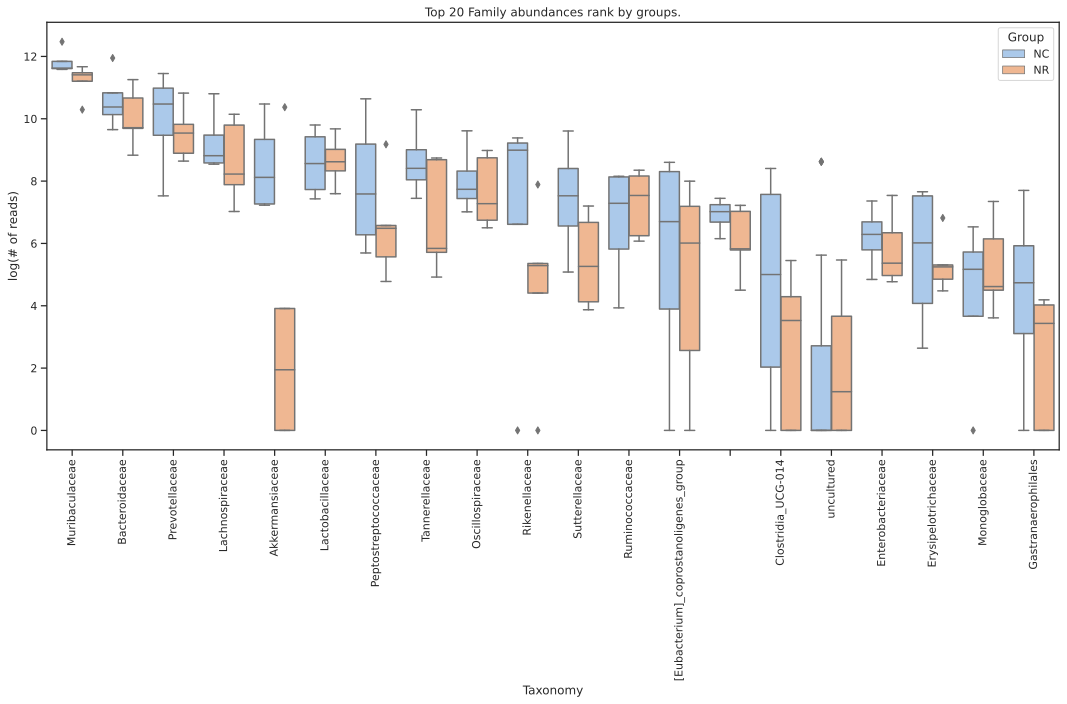

Processing Genus - NC


Processing Genus - NR


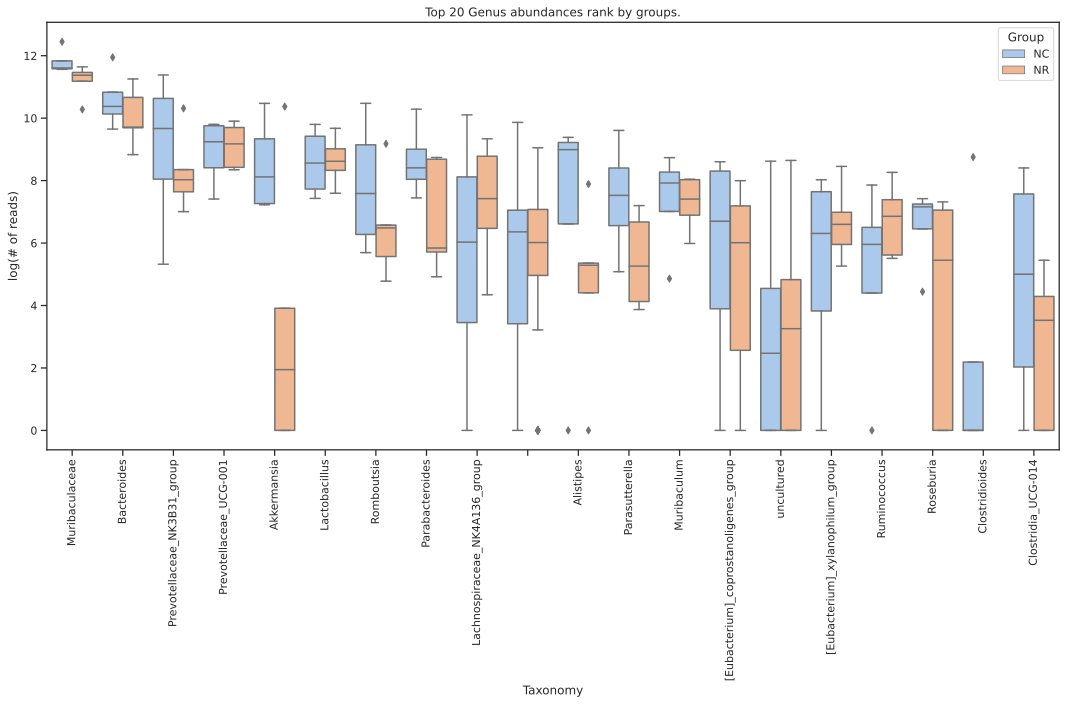

Processing Species - NC


Processing Species - NR


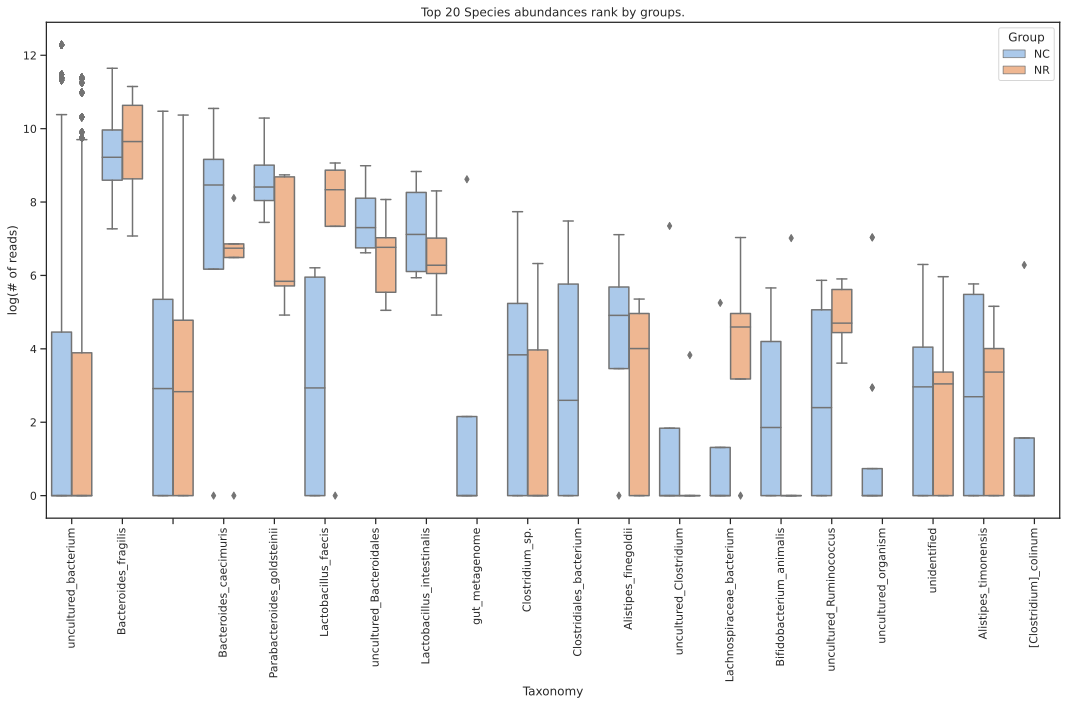

In [21]:
for i in range(7):
    boxplot_rank(tabs, metadata_qa, metatax_qa, groups_values, lvl=i+1, exclude=exclude_tax, gid=class_col, top=top_n)

### 3.2.2. Taxonomic abundance by groups - Make dataframes for each taxonomic level and save to file

Create a dataframe with the taxonomic abundance by groups. The dataframe will have one column for the total abundance on a taxonomic level one for each group and one for each sample. The rows will be the taxons on the taxonomic level. There will be one sheet for each taxonomic level, for each frequency type (relative and absolute).

There are seven taxonomic levels: Kingdom, Phylum, Class, Order, Family, Genus and Species.

Example sheets:
- With absolute frequencies: [link to Google Drive](https://docs.google.com/spreadsheets/d/12vnaEZyOZXDbVBKXQBpEMLW1Y1-bZp1i/edit?usp=sharing&ouid=109330023391628055946&rtpof=true&sd=true)
- With relative frequencies: [link to Google Drive](https://docs.google.com/spreadsheets/d/1WiU2atDOz9rbCFsd3BOzUj3yK59O4b-j/edit?usp=sharing&ouid=109330023391628055946&rtpof=true&sd=true)

In [22]:
# get groups sample-id keys from metadata and asv tables
groups_keys = get_keys_by_group(metadata_df=metadata_df, asv_df=asv_df,group_id=class_col)
print(f'Groups keys: {groups_keys}')

to_filter_terms = None
to_filter_terms = ['uncultured', 'unidentified', 'metagenome', 'human']


# define if the frequencies will be persisted
persist = True

frequency_tables = {'relative-filtered': None, 'absolute-filtered': None, 'relative-all': None, 'absolute-all': None}

# iterate over frequencies types
for tax_tables in frequency_tables.keys():
    print(f'Processing {tax_tables} frequencies')
    # define if frequencies are relative or absolute
    is_relative = True if tax_tables.split('-')[0] == 'relative' else False
    # create a list to store level sheets
    level_sheets = list()
    # iterate over taxonomic levels
    for lvl in range(7):
        print(f'Processing level {lvl} for {tax_tables} frequencies')
        filter_terms = to_filter_terms if tax_tables.split('-')[1] == 'filtered' else None
        # get taxonomic level dataframe
        level_df = get_level_tax_df(table_df=asv_df, metatax_df=metatax_df, level=lvl, groups_keys=groups_keys, round_by=5, normalize=is_relative, filter_terms=filter_terms)
        # append to level sheets
        level_sheets.append(level_df)

    # store frequencies by frequency type
    frequency_tables[tax_tables] = level_sheets

    # persist frequencies to xlsx
    if persist:
        print(f'Persisting {tax_tables} frequencies to xlsx')
        # define xlsx path
        xlsx_path = os.path.join(sheet_folder, f'{tax_tables}_frequencies.xlsx')
        print(f'Xlsx path: {xlsx_path}')
        # create ExcelWriter object to write to xlsx file
        with pd.ExcelWriter(xlsx_path) as writer:
            # iterate over level sheets
            for i, lvl_df in enumerate(level_sheets):
                #df = (lvl*100).round(5)
                lvl_df.to_excel(writer, sheet_name=f'{tax_level[i]}')

Groups keys: {'NC': ['S210421121673', 'S210421121674', 'S210421121675', 'S210421121676'], 'NR': ['S210421121677', 'S210421121678', 'S210421121679', 'S210421121680', 'S210421121681']}
Processing relative-filtered frequencies
Processing level 0 for relative-filtered frequencies
Processing level 1 for relative-filtered frequencies
Processing level 2 for relative-filtered frequencies
Processing level 3 for relative-filtered frequencies
Processing level 4 for relative-filtered frequencies
Processing level 5 for relative-filtered frequencies
Processing level 6 for relative-filtered frequencies
Persisting relative-filtered frequencies to xlsx
Xlsx path: /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/sheets/relative-filtered_frequencies.xlsx
Processing absolute-filtered frequencies
Processing level 0 for absolute-filtered frequencies
Processing level 1 for absolute-filtered frequencies
Processing level 2 for absolute-filtered frequencies
Processing le

Processing level 6 for absolute-filtered frequencies
Persisting absolute-filtered frequencies to xlsx
Xlsx path: /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/sheets/absolute-filtered_frequencies.xlsx
Processing relative-all frequencies
Processing level 0 for relative-all frequencies
Processing level 1 for relative-all frequencies
Processing level 2 for relative-all frequencies
Processing level 3 for relative-all frequencies
Processing level 4 for relative-all frequencies
Processing level 5 for relative-all frequencies
Processing level 6 for relative-all frequencies
Persisting relative-all frequencies to xlsx
Xlsx path: /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/sheets/relative-all_frequencies.xlsx


Processing absolute-all frequencies
Processing level 0 for absolute-all frequencies
Processing level 1 for absolute-all frequencies
Processing level 2 for absolute-all frequencies
Processing level 3 for absolute-all frequencies
Processing level 4 for absolute-all frequencies
Processing level 5 for absolute-all frequencies
Processing level 6 for absolute-all frequencies
Persisting absolute-all frequencies to xlsx
Xlsx path: /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/sheets/absolute-all_frequencies.xlsx


### 3.2.3. Taxonomic abundance by groups - Barplots with statistical significance

We create boxplot with the abundance of the top N most abundant taxonomy on each taxonomic level. The boxplot will be grouped by groups and will have the abundance on the y-axis and the taxonomies on the x-axis. There will be one boxplot for each taxonomic level, for each frequency type (relative and absolute).

There are seven taxonomic levels: Kingdom, Phylum, Class, Order, Family, Genus and Species.

Example boxplot:
- [boxplot-absolute-all-abundance-Species-top-10.svg](https://drive.google.com/file/d/12Y7I5i4Dalk7nwh4cu-t_4C4SIwL1VTS/view?usp=sharing)
- [boxplot-absolute-filtered-abundance-Species-top-10.svg](https://drive.google.com/file/d/1QZMdvA8gW5j0l5uBvPJtX5kmHr4Uier0/view?usp=sharing)
- [boxplot-relative-all-abundance-Species-top-10.svg](https://drive.google.com/file/d/1n0CT7Cgj-1BYjcS7uhDH6sXTn7PFoL5V/view?usp=sharing)
- [boxplot-relative-filtered-abundance-Species-top-10.svg](https://drive.google.com/file/d/1qqdAu6STaDo7prxlmQSGdQ88dWq1BUWT/view?usp=sharing)

**p-value** annotation legend:
ns: 0.05 < p <= 1.00
*: 0.01 < p <= 0.05
**: 0.001 < p <= 0.01
***: 0.0001 < p <= 0.001
****: p <= 0.0001

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Bacteria_NC v.s. Bacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-filtered-abundance-Kingdom-top-10.svg - using relative-filtered frequencies


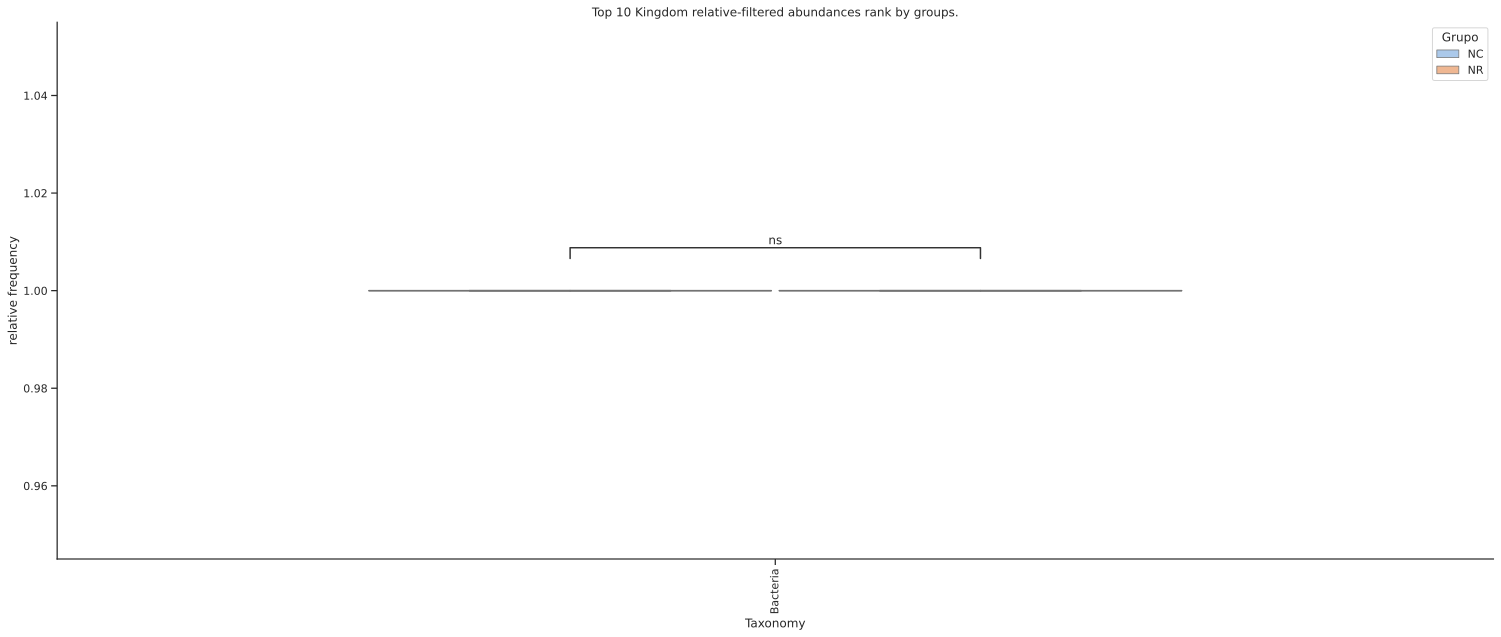

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Campilobacterota_NC v.s. Campilobacterota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Firmicutes_NC v.s. Firmicutes_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Bacteroidota_NC v.s. Bacteroidota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00


Verrucomicrobiota_NC v.s. Verrucomicrobiota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.887e-01 U_stat=1.700e+01
Proteobacteria_NC v.s. Proteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
Actinobacteriota_NC v.s. Actinobacteriota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00
Cyanobacteria_NC v.s. Cyanobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01


Patescibacteria_NC v.s. Patescibacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Deferribacterota_NC v.s. Deferribacterota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.302e-01 U_stat=1.700e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-filtered-abundance-Phylum-top-10.svg - using relative-filtered frequencies


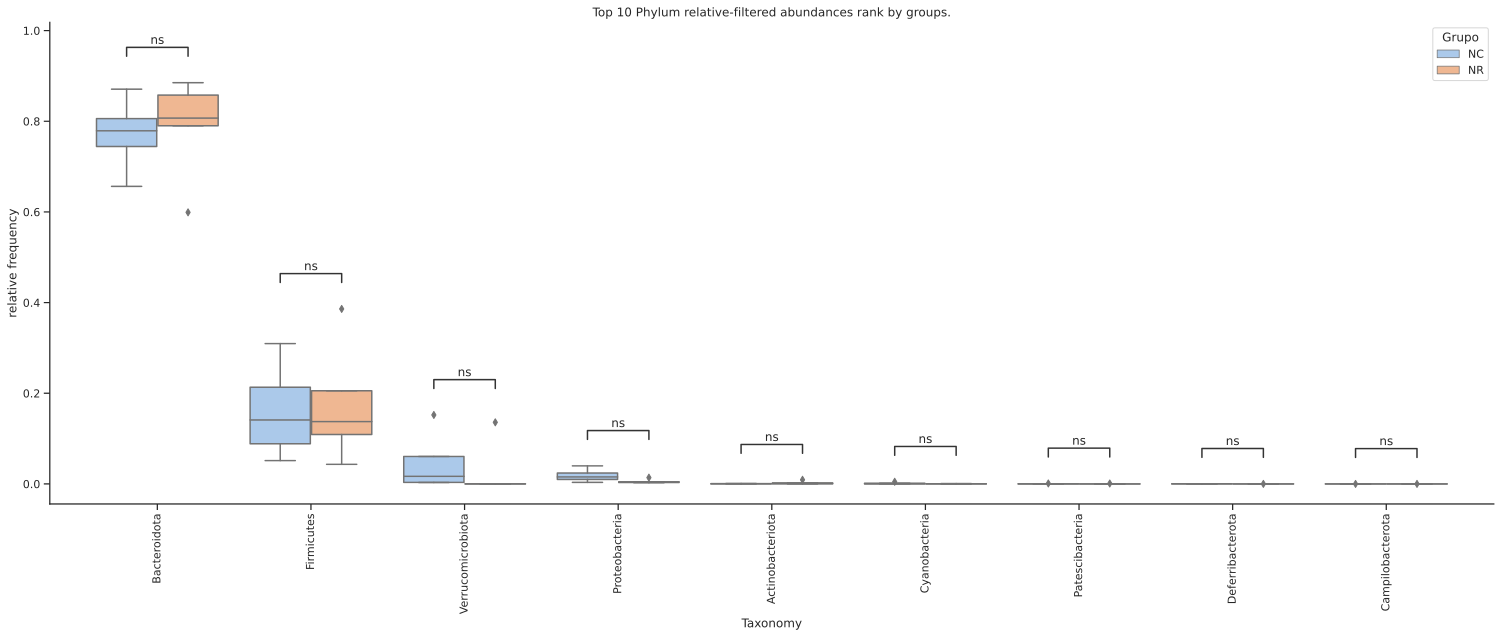

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Saccharimonadia_NC v.s. Saccharimonadia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Coriobacteriia_NC v.s. Coriobacteriia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Clostridia_NC v.s. Clostridia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01


Bacteroidia_NC v.s. Bacteroidia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Bacilli_NC v.s. Bacilli_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.000e+00
Verrucomicrobiae_NC v.s. Verrucomicrobiae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01


Gammaproteobacteria_NC v.s. Gammaproteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01
Alphaproteobacteria_NC v.s. Alphaproteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Vampirivibrionia_NC v.s. Vampirivibrionia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01


Actinobacteria_NC v.s. Actinobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.150e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-filtered-abundance-Class-top-10.svg - using relative-filtered frequencies


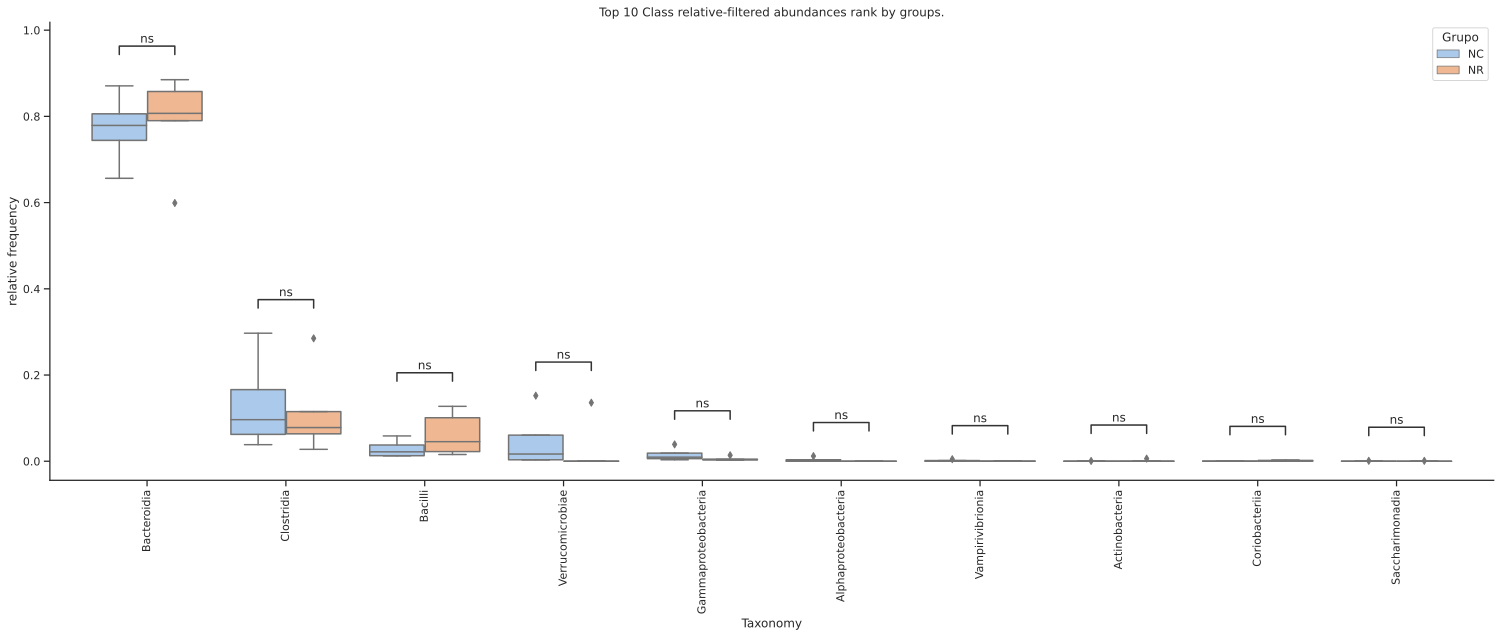

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Clostridia_UCG-014_NC v.s. Clostridia_UCG-014_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Erysipelotrichales_NC v.s. Erysipelotrichales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Lachnospirales_NC v.s. Lachnospirales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Bacteroidales_NC v.s. Bacteroidales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Verrucomicrobiales_NC v.s. Verrucomicrobiales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Oscillospirales_NC v.s. Oscillospirales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Lactobacillales_NC v.s. Lactobacillales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.000e+00


Peptostreptococcales-Tissierellales_NC v.s. Peptostreptococcales-Tissierellales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Burkholderiales_NC v.s. Burkholderiales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.100e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-filtered-abundance-Order-top-10.svg - using relative-filtered frequencies


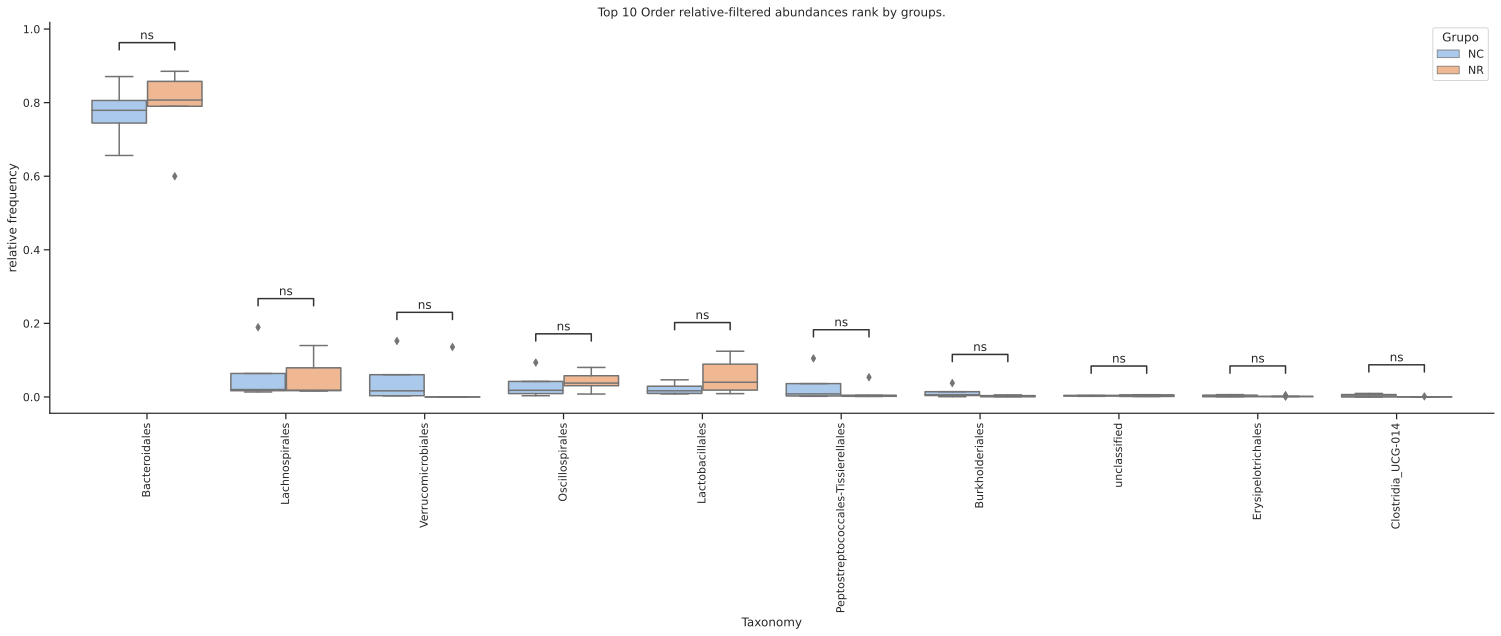

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rikenellaceae_NC v.s. Rikenellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.550e+01
Oscillospiraceae_NC v.s. Oscillospiraceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00
Bacteroidaceae_NC v.s. Bacteroidaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Muribaculaceae_NC v.s. Muribaculaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00
Prevotellaceae_NC v.s. Prevotellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Lachnospiraceae_NC v.s. Lachnospiraceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.100e+01
Akkermansiaceae_NC v.s. Akkermansiaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01


Lactobacillaceae_NC v.s. Lactobacillaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.000e+00


Peptostreptococcaceae_NC v.s. Peptostreptococcaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Tannerellaceae_NC v.s. Tannerellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-filtered-abundance-Family-top-10.svg - using relative-filtered frequencies


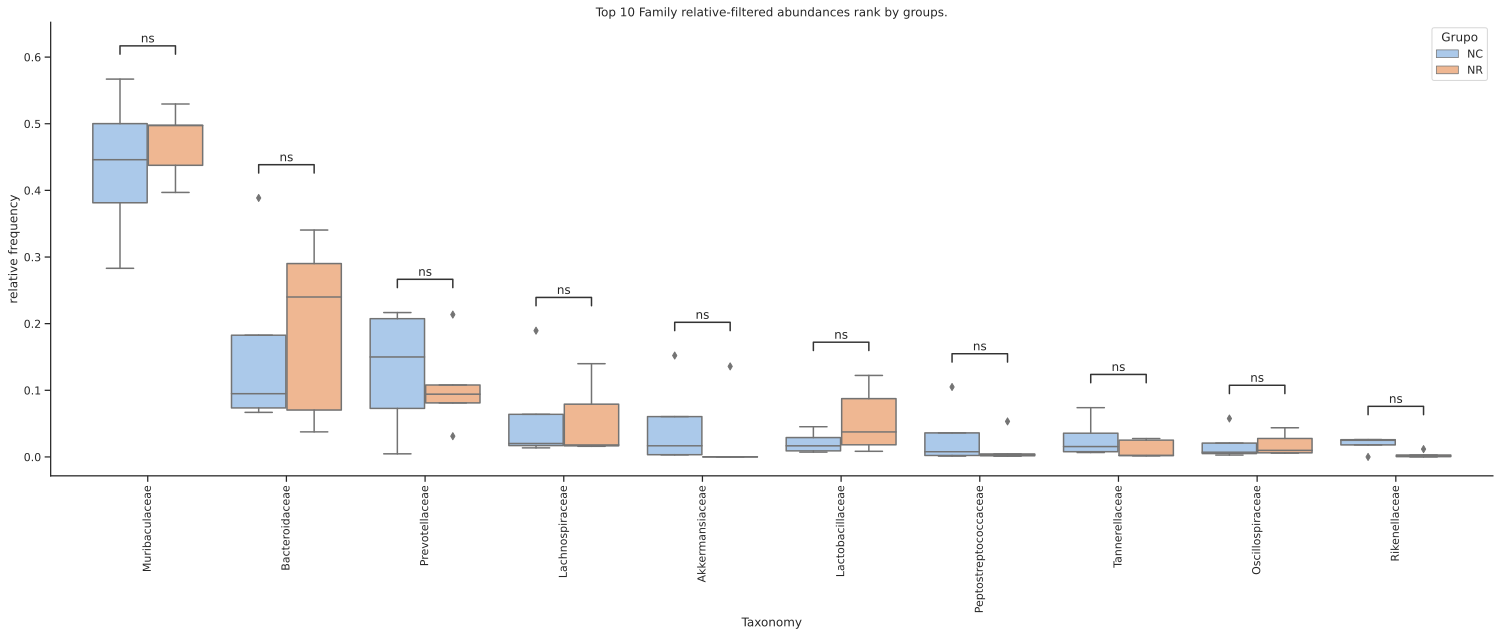

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lachnospiraceae_NK4A136_group_NC v.s. Lachnospiraceae_NK4A136_group_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Parabacteroides_NC v.s. Parabacteroides_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Bacteroides_NC v.s. Bacteroides_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Muribaculaceae_NC v.s. Muribaculaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00
Prevotellaceae_NK3B31_group_NC v.s. Prevotellaceae_NK3B31_group_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Prevotellaceae_UCG-001_NC v.s. Prevotellaceae_UCG-001_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00


Akkermansia_NC v.s. Akkermansia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Lactobacillus_NC v.s. Lactobacillus_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.000e+00


Romboutsia_NC v.s. Romboutsia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-filtered-abundance-Genus-top-10.svg - using relative-filtered frequencies


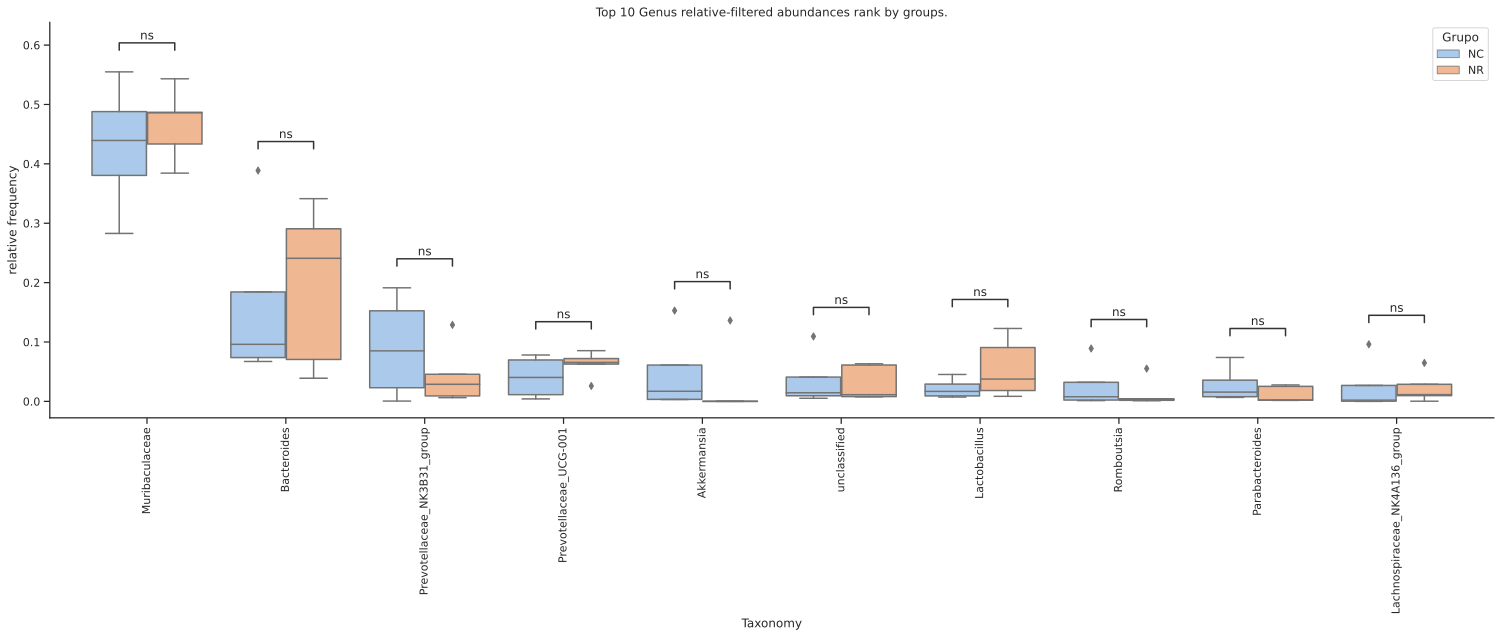

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lachnospiraceae_bacterium_NC v.s. Lachnospiraceae_bacterium_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.500e+00
Alistipes_finegoldii_NC v.s. Alistipes_finegoldii_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Bacteroides_fragilis_NC v.s. Bacteroides_fragilis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00


unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01
Bacteroides_caecimuris_NC v.s. Bacteroides_caecimuris_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.550e+01
Parabacteroides_goldsteinii_NC v.s. Parabacteroides_goldsteinii_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01
Lactobacillus_faecis_NC v.s. Lactobacillus_faecis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+00


Lactobacillus_intestinalis_NC v.s. Lactobacillus_intestinalis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Clostridium_sp._NC v.s. Clostridium_sp._NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Clostridiales_bacterium_NC v.s. Clostridiales_bacterium_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-filtered-abundance-Species-top-10.svg - using relative-filtered frequencies


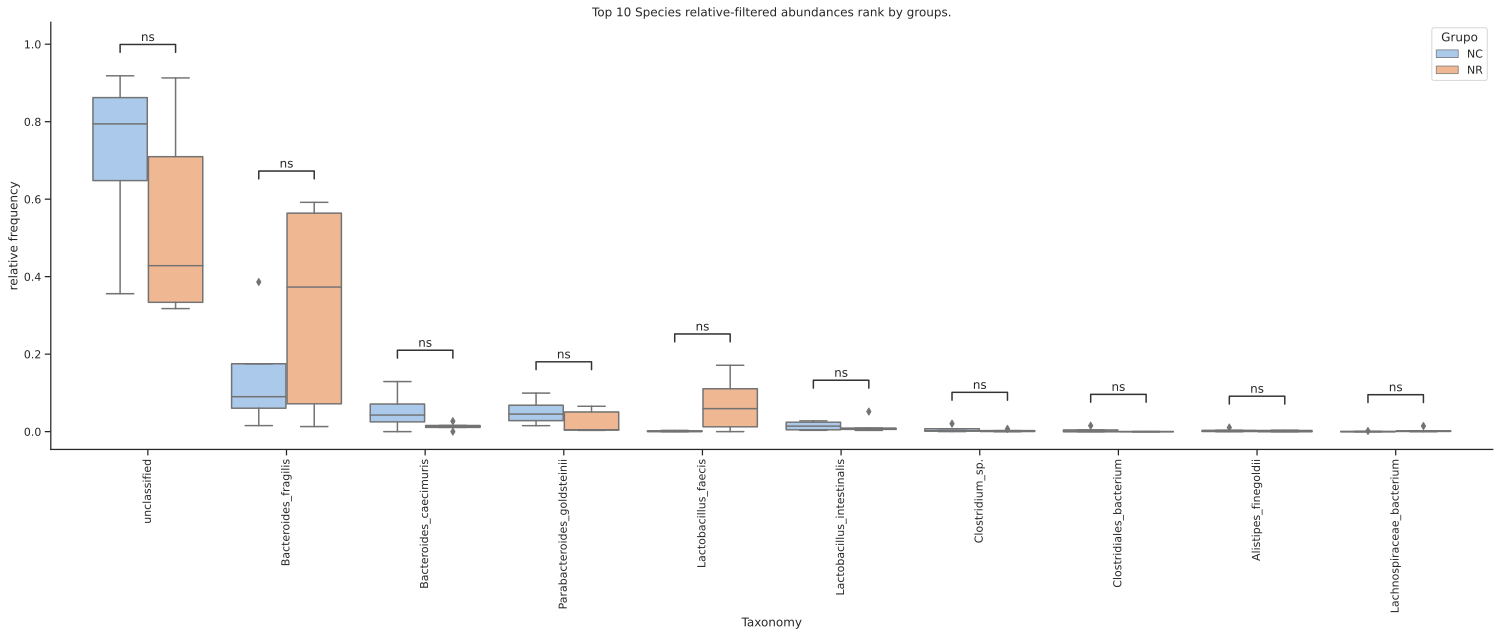

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Bacteria_NC v.s. Bacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.175e-02 U_stat=1.900e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-filtered-abundance-Kingdom-top-10.svg - using absolute-filtered frequencies


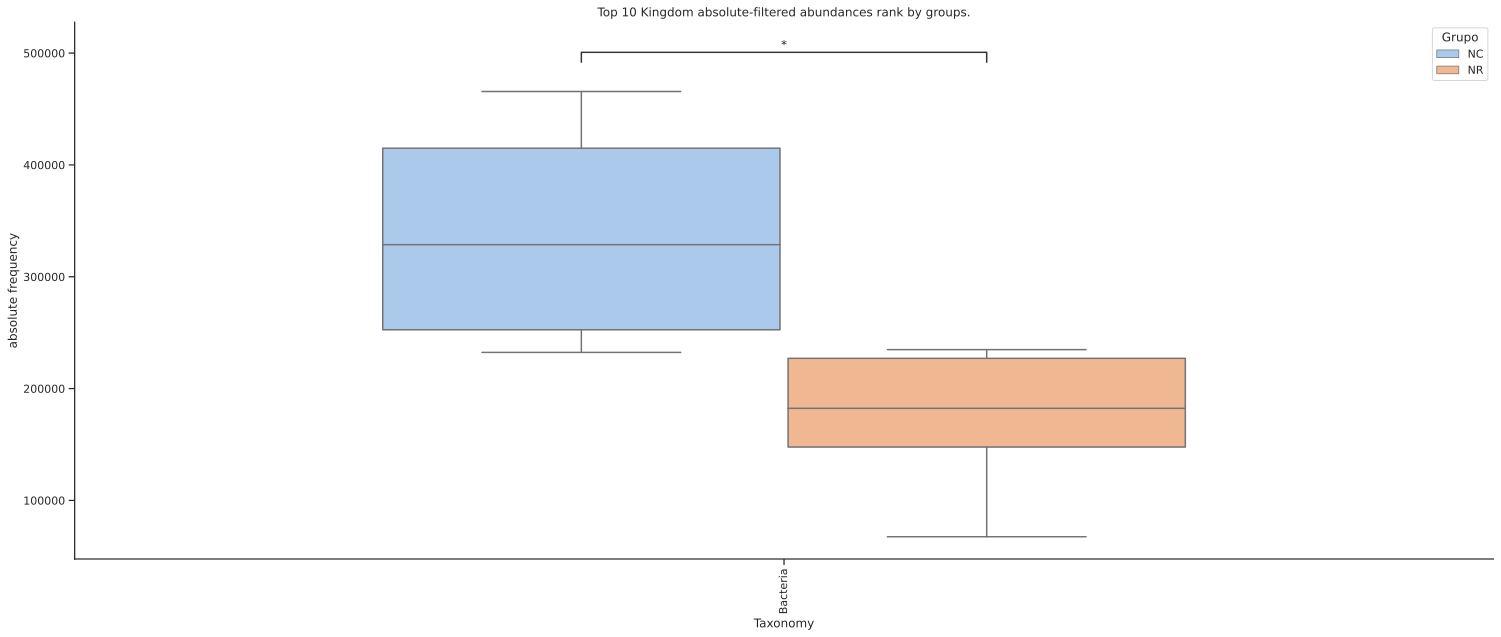

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Campilobacterota_NC v.s. Campilobacterota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.050e+01
Firmicutes_NC v.s. Firmicutes_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01
Bacteroidota_NC v.s. Bacteroidota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01


Verrucomicrobiota_NC v.s. Verrucomicrobiota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.887e-01 U_stat=1.700e+01
Proteobacteria_NC v.s. Proteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Actinobacteriota_NC v.s. Actinobacteriota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Cyanobacteria_NC v.s. Cyanobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Patescibacteria_NC v.s. Patescibacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Deferribacterota_NC v.s. Deferribacterota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.302e-01 U_stat=1.700e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-filtered-abundance-Phylum-top-10.svg - using absolute-filtered frequencies


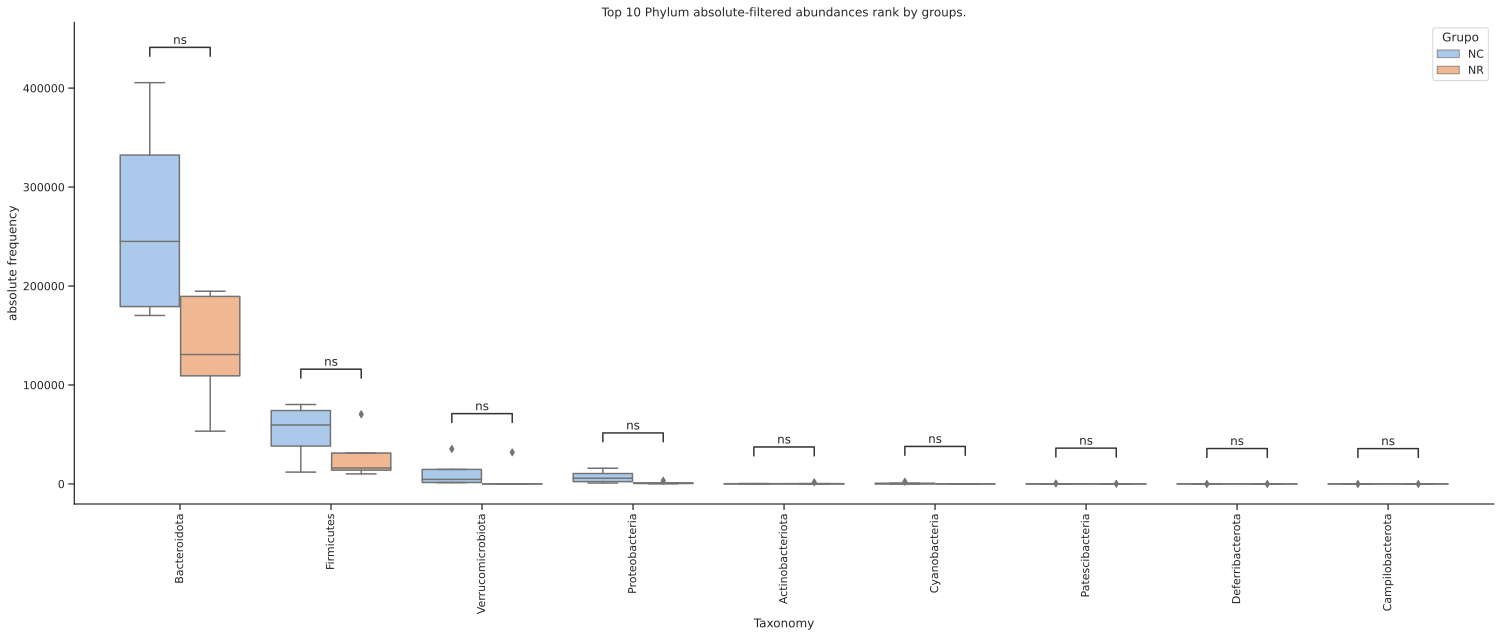

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Saccharimonadia_NC v.s. Saccharimonadia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Coriobacteriia_NC v.s. Coriobacteriia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Clostridia_NC v.s. Clostridia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Bacteroidia_NC v.s. Bacteroidia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
Bacilli_NC v.s. Bacilli_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Verrucomicrobiae_NC v.s. Verrucomicrobiae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Gammaproteobacteria_NC v.s. Gammaproteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01


Alphaproteobacteria_NC v.s. Alphaproteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Vampirivibrionia_NC v.s. Vampirivibrionia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01
Actinobacteria_NC v.s. Actinobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.150e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-filtered-abundance-Class-top-10.svg - using absolute-filtered frequencies


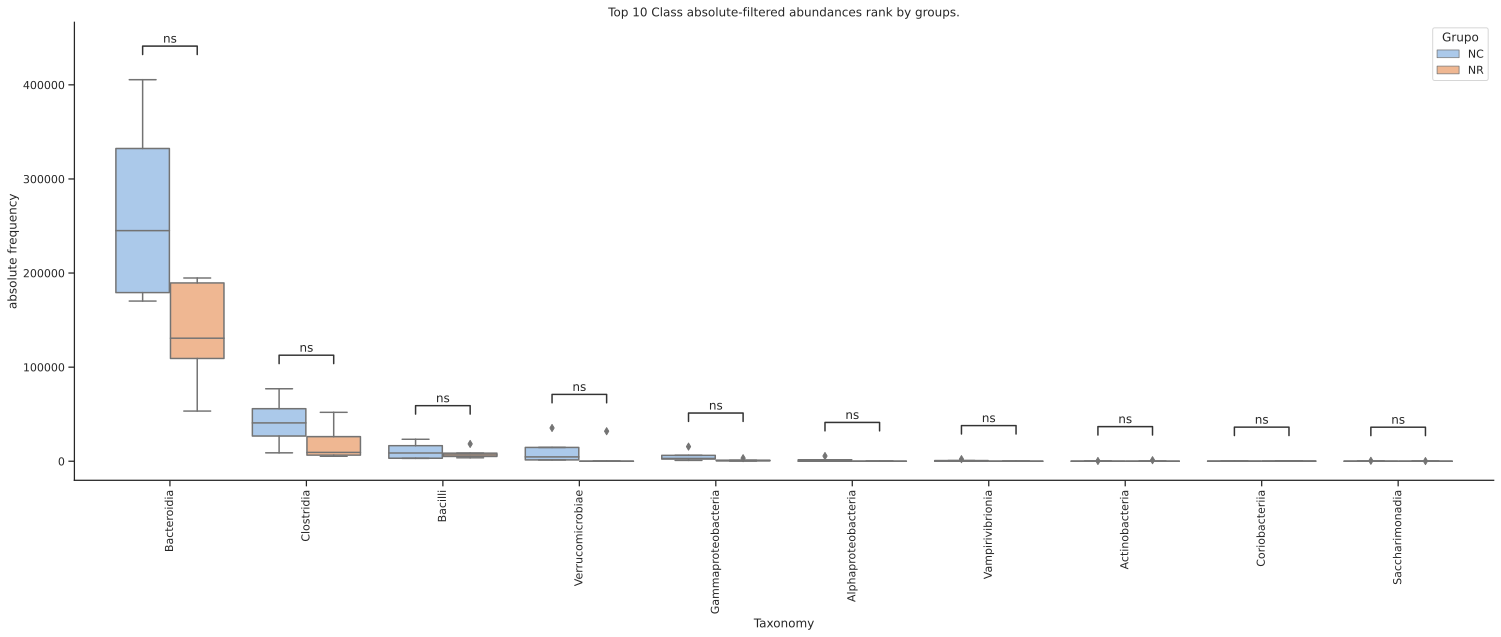

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Clostridia_UCG-014_NC v.s. Clostridia_UCG-014_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Erysipelotrichales_NC v.s. Erysipelotrichales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Lachnospirales_NC v.s. Lachnospirales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01


Bacteroidales_NC v.s. Bacteroidales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
Verrucomicrobiales_NC v.s. Verrucomicrobiales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Oscillospirales_NC v.s. Oscillospirales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Lactobacillales_NC v.s. Lactobacillales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Peptostreptococcales-Tissierellales_NC v.s. Peptostreptococcales-Tissierellales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Burkholderiales_NC v.s. Burkholderiales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-filtered-abundance-Order-top-10.svg - using absolute-filtered frequencies


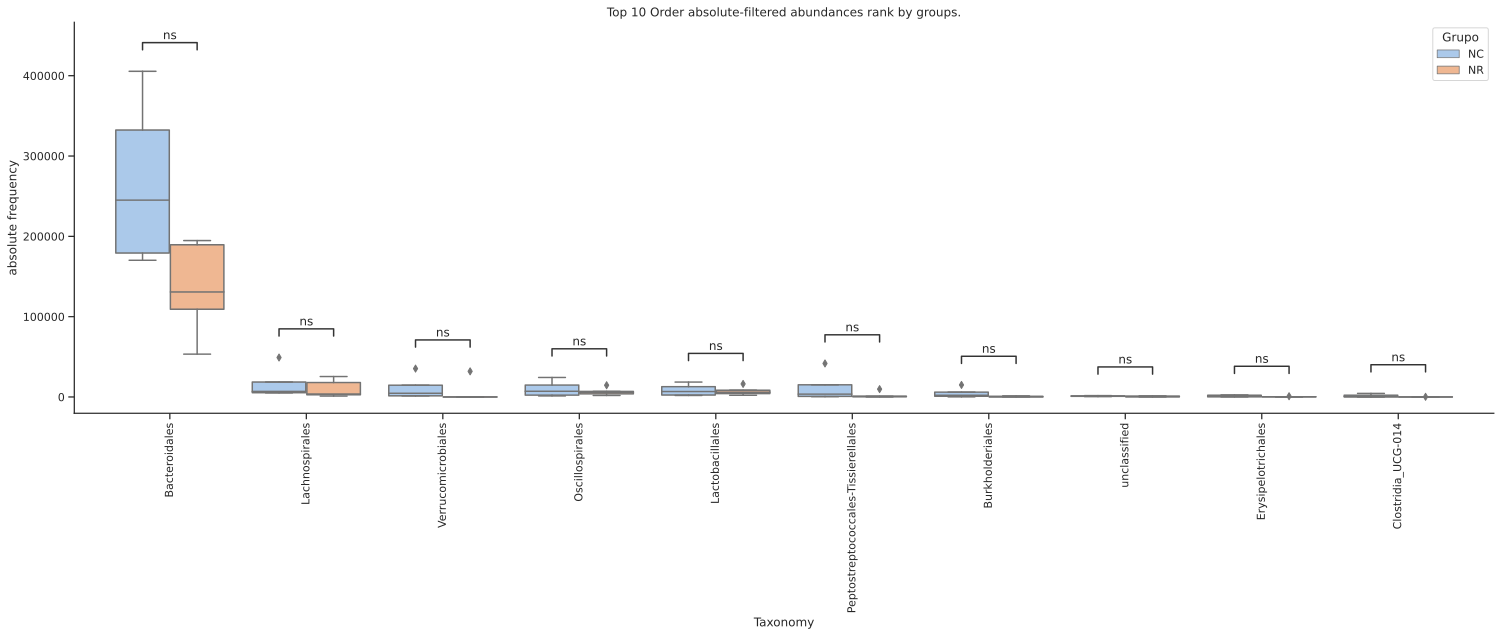

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rikenellaceae_NC v.s. Rikenellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.550e+01
Oscillospiraceae_NC v.s. Oscillospiraceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Bacteroidaceae_NC v.s. Bacteroidaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01


Muribaculaceae_NC v.s. Muribaculaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Prevotellaceae_NC v.s. Prevotellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Lachnospiraceae_NC v.s. Lachnospiraceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Akkermansiaceae_NC v.s. Akkermansiaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01


Lactobacillaceae_NC v.s. Lactobacillaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Peptostreptococcaceae_NC v.s. Peptostreptococcaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Tannerellaceae_NC v.s. Tannerellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-filtered-abundance-Family-top-10.svg - using absolute-filtered frequencies


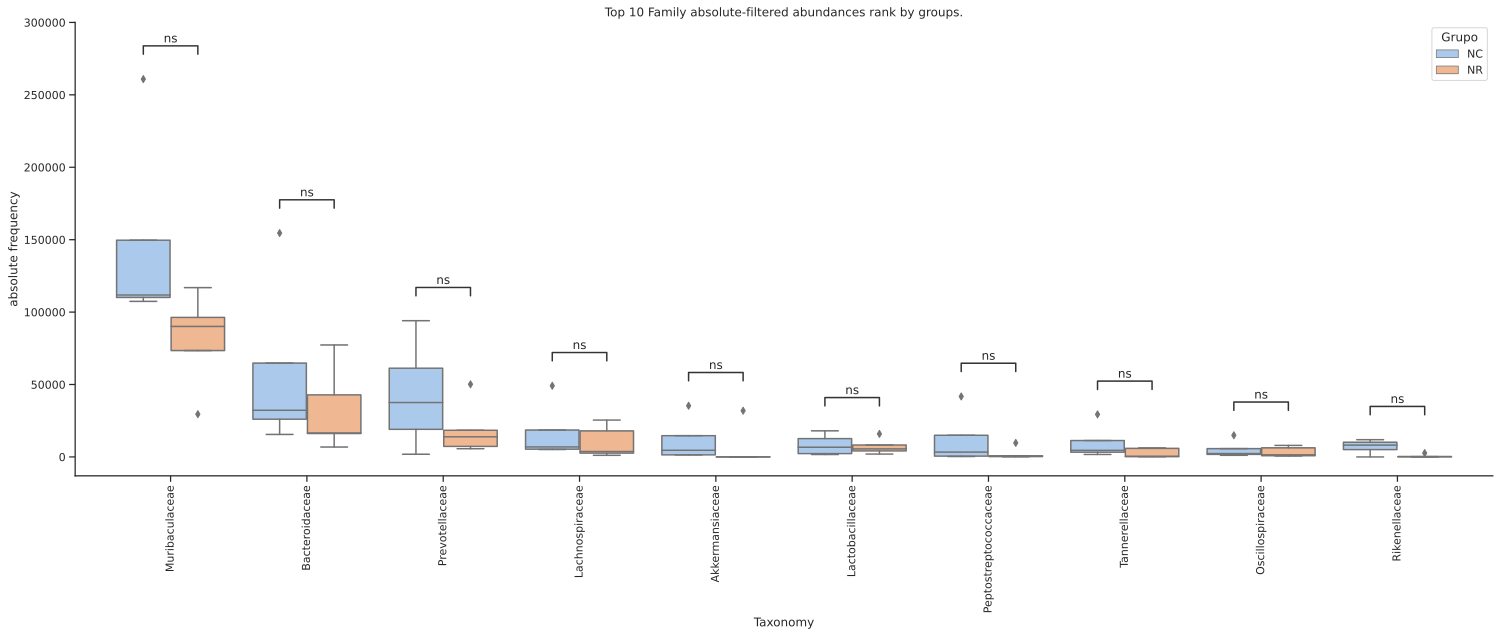

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lachnospiraceae_NK4A136_group_NC v.s. Lachnospiraceae_NK4A136_group_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Parabacteroides_NC v.s. Parabacteroides_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Bacteroides_NC v.s. Bacteroides_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01


Muribaculaceae_NC v.s. Muribaculaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Prevotellaceae_NK3B31_group_NC v.s. Prevotellaceae_NK3B31_group_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Prevotellaceae_UCG-001_NC v.s. Prevotellaceae_UCG-001_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Akkermansia_NC v.s. Akkermansia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01


unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Lactobacillus_NC v.s. Lactobacillus_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Romboutsia_NC v.s. Romboutsia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-filtered-abundance-Genus-top-10.svg - using absolute-filtered frequencies


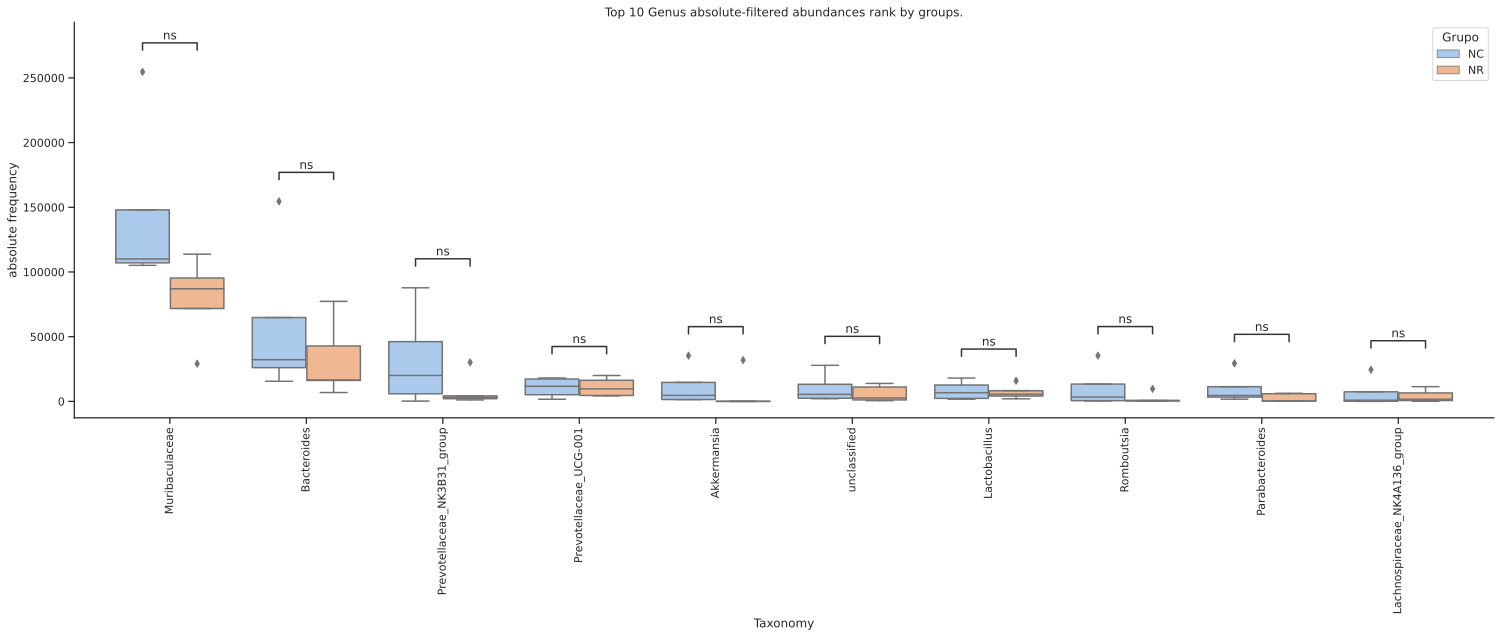

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lachnospiraceae_bacterium_NC v.s. Lachnospiraceae_bacterium_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.500e+00
Alistipes_finegoldii_NC v.s. Alistipes_finegoldii_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Bacteroides_fragilis_NC v.s. Bacteroides_fragilis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.587e-01 U_stat=2.000e+01
Bacteroides_caecimuris_NC v.s. Bacteroides_caecimuris_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.550e+01
Parabacteroides_goldsteinii_NC v.s. Parabacteroides_goldsteinii_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Lactobacillus_faecis_NC v.s. Lactobacillus_faecis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+00


Lactobacillus_intestinalis_NC v.s. Lactobacillus_intestinalis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Clostridium_sp._NC v.s. Clostridium_sp._NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Clostridiales_bacterium_NC v.s. Clostridiales_bacterium_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-filtered-abundance-Species-top-10.svg - using absolute-filtered frequencies


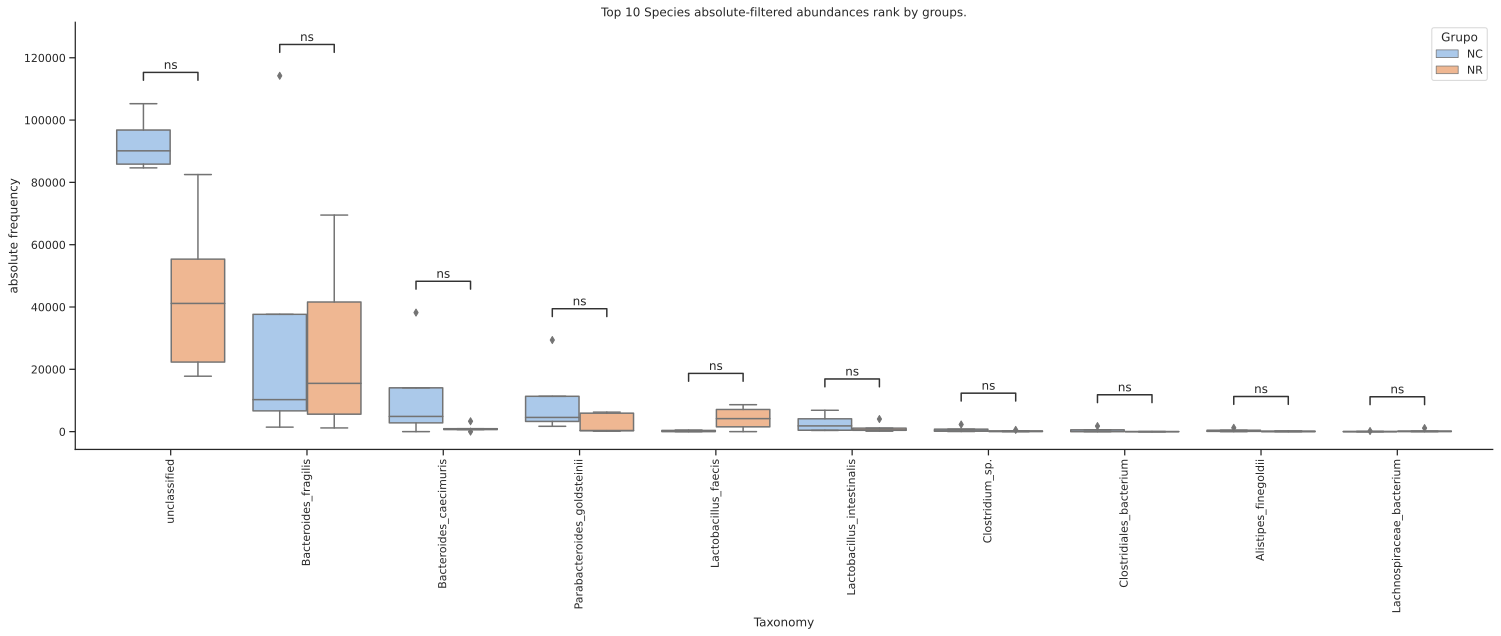

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Bacteria_NC v.s. Bacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-all-abundance-Kingdom-top-10.svg - using relative-all frequencies


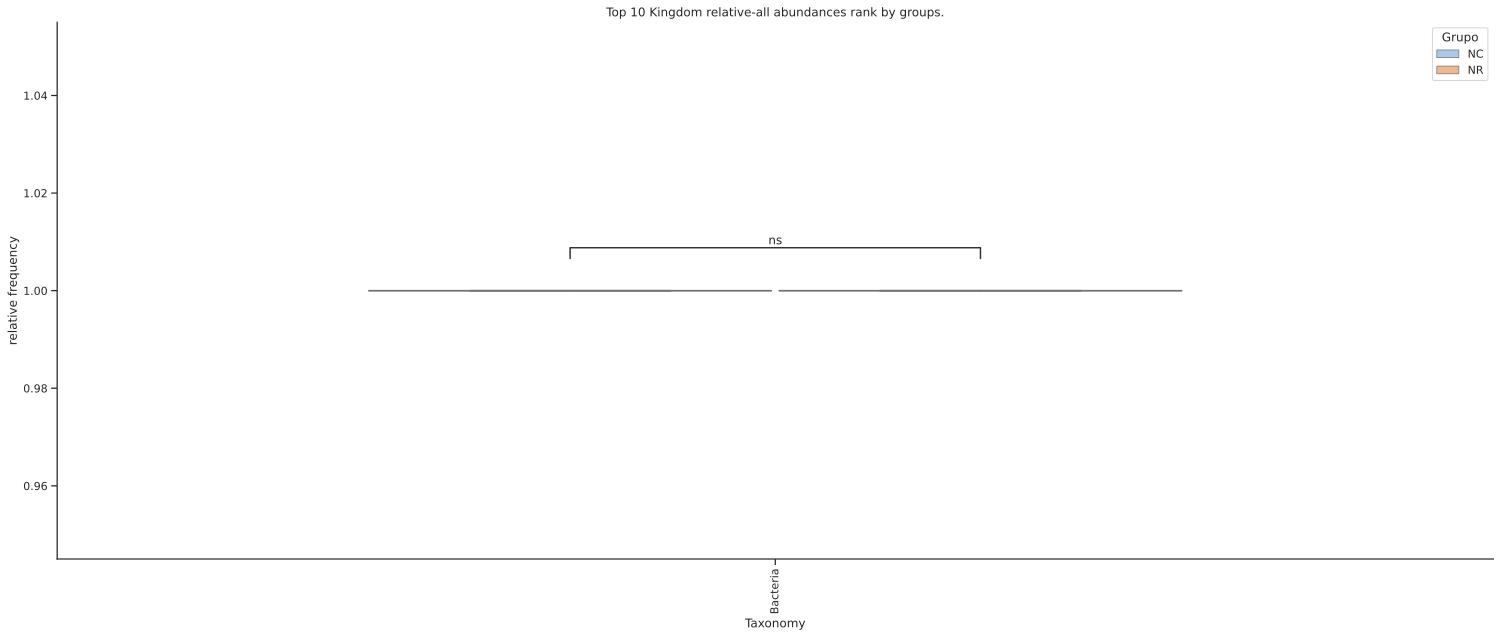

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Campilobacterota_NC v.s. Campilobacterota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Firmicutes_NC v.s. Firmicutes_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Bacteroidota_NC v.s. Bacteroidota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00


Verrucomicrobiota_NC v.s. Verrucomicrobiota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.887e-01 U_stat=1.700e+01
Proteobacteria_NC v.s. Proteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
Actinobacteriota_NC v.s. Actinobacteriota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00
Cyanobacteria_NC v.s. Cyanobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01


Patescibacteria_NC v.s. Patescibacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Deferribacterota_NC v.s. Deferribacterota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.302e-01 U_stat=1.700e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-all-abundance-Phylum-top-10.svg - using relative-all frequencies


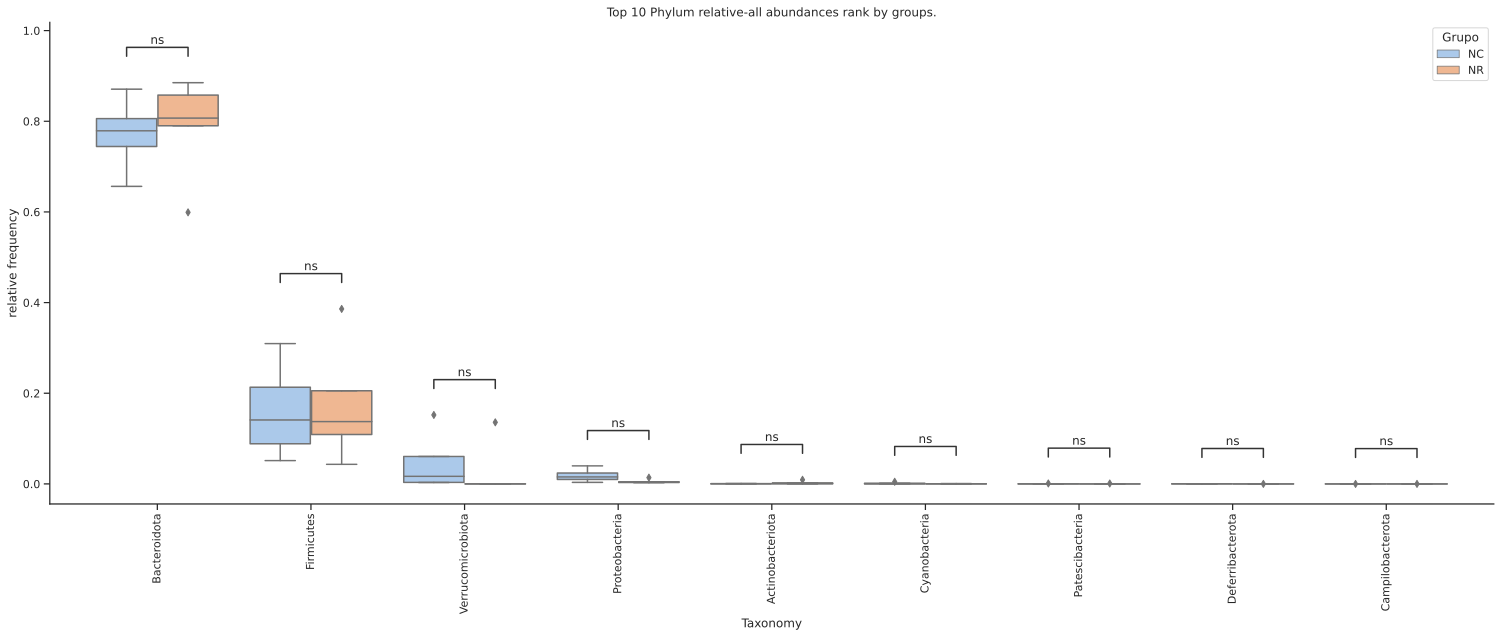

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Saccharimonadia_NC v.s. Saccharimonadia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Coriobacteriia_NC v.s. Coriobacteriia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Clostridia_NC v.s. Clostridia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01


Bacteroidia_NC v.s. Bacteroidia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Bacilli_NC v.s. Bacilli_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=5.000e+00
Verrucomicrobiae_NC v.s. Verrucomicrobiae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Gammaproteobacteria_NC v.s. Gammaproteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Alphaproteobacteria_NC v.s. Alphaproteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Vampirivibrionia_NC v.s. Vampirivibrionia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Actinobacteria_NC v.s. Actinobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.150e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-all-abundance-Class-top-10.svg - using relative-all frequencies


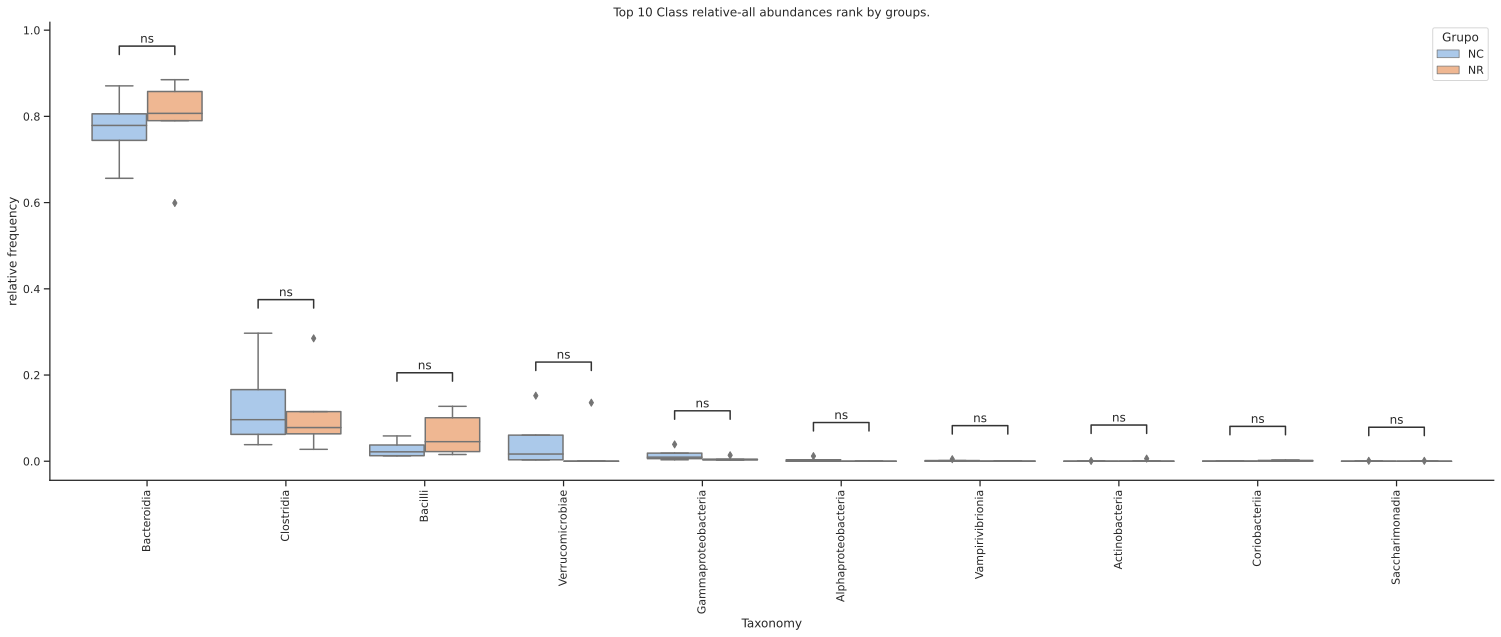

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Clostridia_UCG-014_NC v.s. Clostridia_UCG-014_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Erysipelotrichales_NC v.s. Erysipelotrichales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Lachnospirales_NC v.s. Lachnospirales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Bacteroidales_NC v.s. Bacteroidales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Verrucomicrobiales_NC v.s. Verrucomicrobiales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Oscillospirales_NC v.s. Oscillospirales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Lactobacillales_NC v.s. Lactobacillales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.000e+00


Peptostreptococcales-Tissierellales_NC v.s. Peptostreptococcales-Tissierellales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Burkholderiales_NC v.s. Burkholderiales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.100e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-all-abundance-Order-top-10.svg - using relative-all frequencies


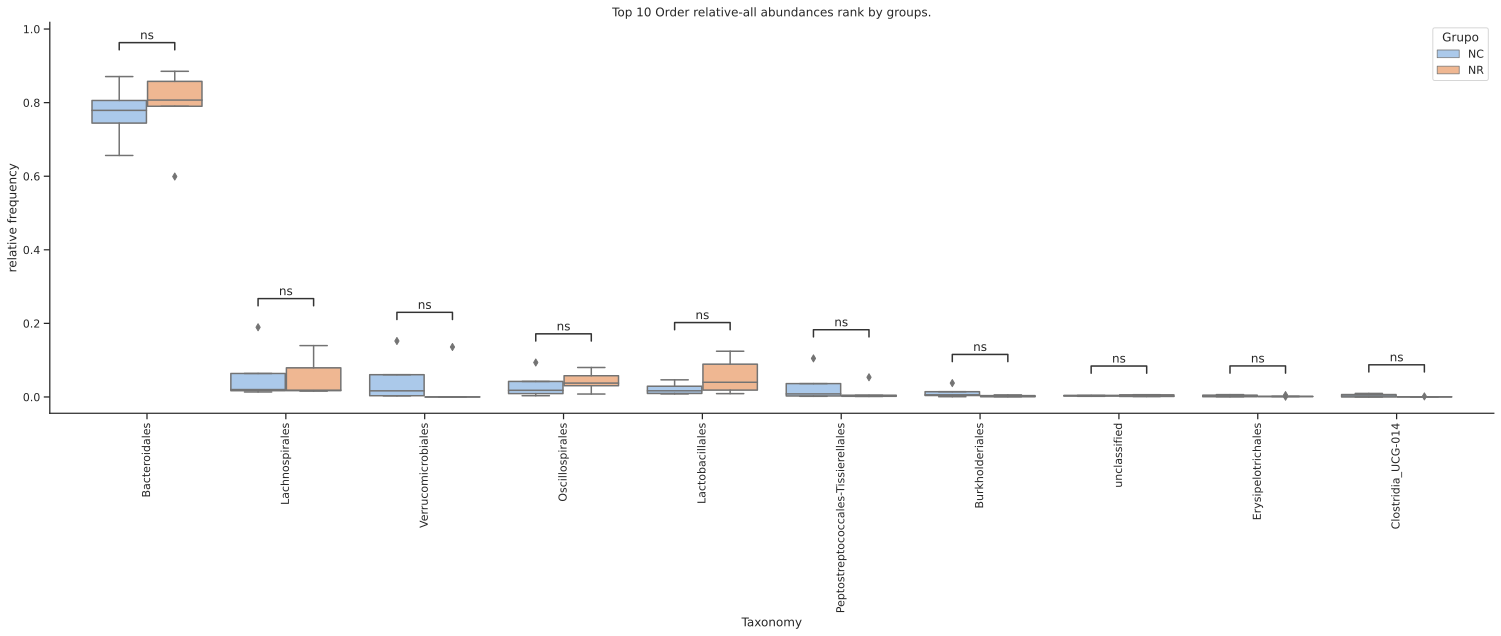

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rikenellaceae_NC v.s. Rikenellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.550e+01
Oscillospiraceae_NC v.s. Oscillospiraceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Bacteroidaceae_NC v.s. Bacteroidaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Muribaculaceae_NC v.s. Muribaculaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00
Prevotellaceae_NC v.s. Prevotellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Lachnospiraceae_NC v.s. Lachnospiraceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.100e+01
Akkermansiaceae_NC v.s. Akkermansiaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01


Lactobacillaceae_NC v.s. Lactobacillaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.000e+00
Peptostreptococcaceae_NC v.s. Peptostreptococcaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Tannerellaceae_NC v.s. Tannerellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-all-abundance-Family-top-10.svg - using relative-all frequencies


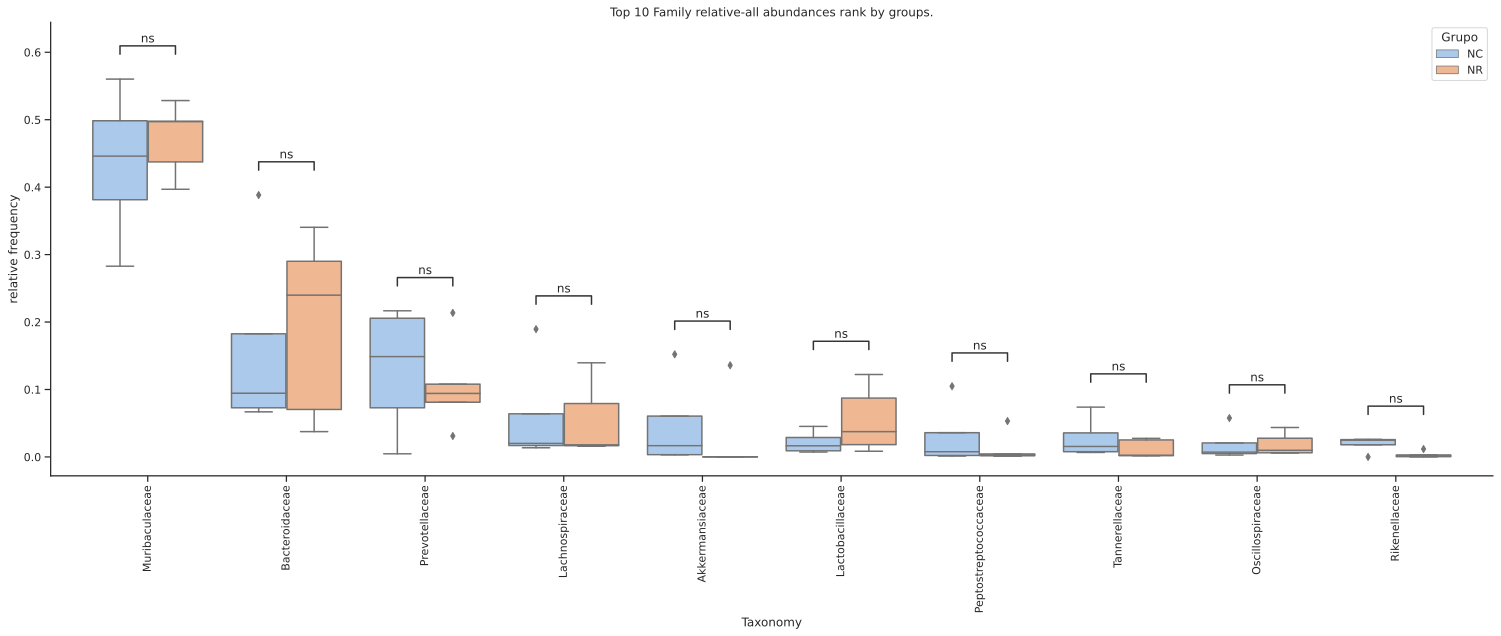

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lachnospiraceae_NK4A136_group_NC v.s. Lachnospiraceae_NK4A136_group_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Parabacteroides_NC v.s. Parabacteroides_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Bacteroides_NC v.s. Bacteroides_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Muribaculaceae_NC v.s. Muribaculaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00
Prevotellaceae_NK3B31_group_NC v.s. Prevotellaceae_NK3B31_group_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Prevotellaceae_UCG-001_NC v.s. Prevotellaceae_UCG-001_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=7.000e+00
Akkermansia_NC v.s. Akkermansia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01


unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Lactobacillus_NC v.s. Lactobacillus_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.000e+00
Romboutsia_NC v.s. Romboutsia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-all-abundance-Genus-top-10.svg - using relative-all frequencies


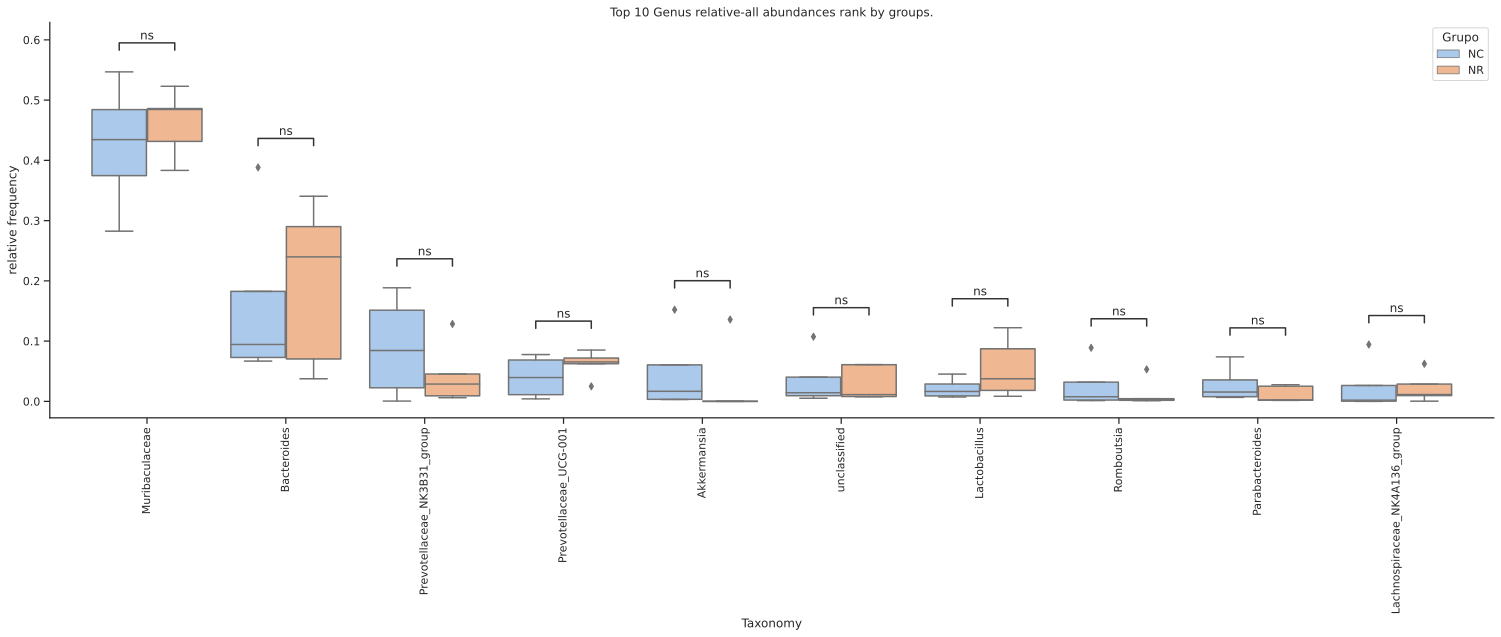

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Clostridium_sp._NC v.s. Clostridium_sp._NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
gut_metagenome_NC v.s. gut_metagenome_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.250e+01
unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


uncultured_bacterium_NC v.s. uncultured_bacterium_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Bacteroides_fragilis_NC v.s. Bacteroides_fragilis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=8.000e+00
Bacteroides_caecimuris_NC v.s. Bacteroides_caecimuris_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.350e+01
Parabacteroides_goldsteinii_NC v.s. Parabacteroides_goldsteinii_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01


Lactobacillus_faecis_NC v.s. Lactobacillus_faecis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+00
uncultured_Bacteroidales_NC v.s. uncultured_Bacteroidales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Lactobacillus_intestinalis_NC v.s. Lactobacillus_intestinalis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-relative-all-abundance-Species-top-10.svg - using relative-all frequencies


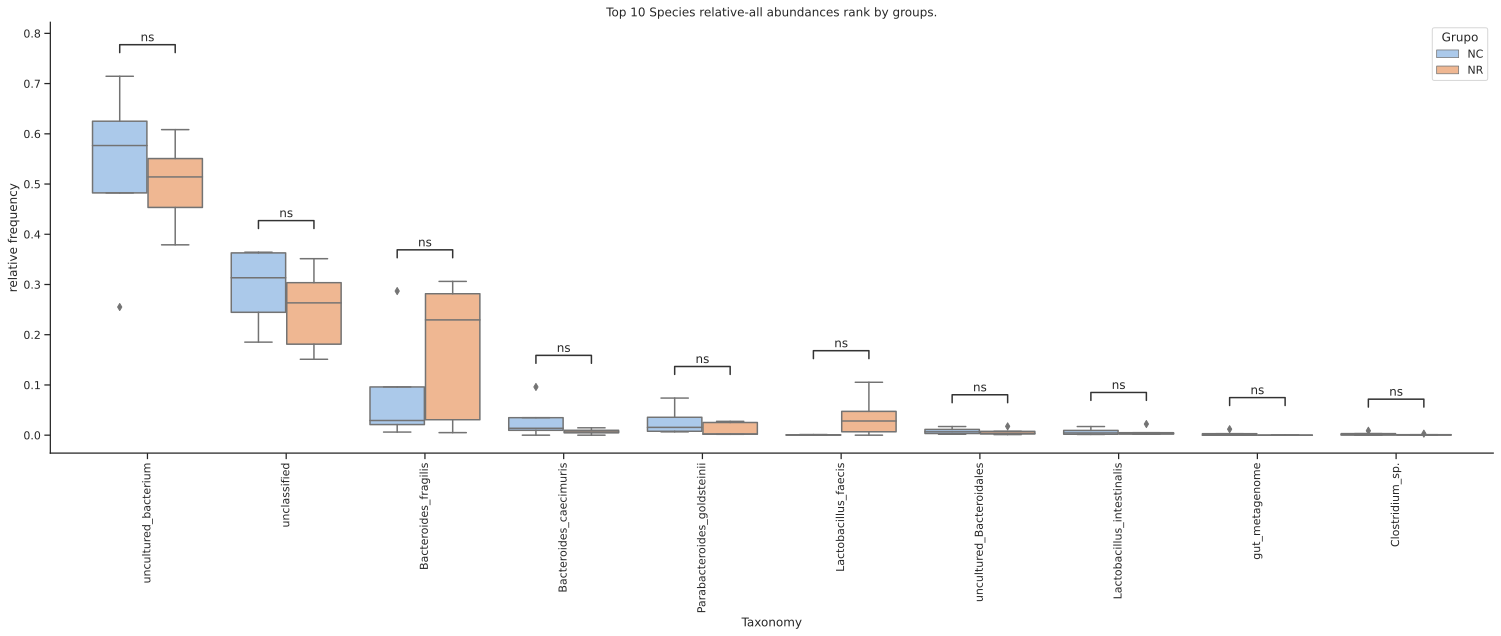

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Bacteria_NC v.s. Bacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.175e-02 U_stat=1.900e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-all-abundance-Kingdom-top-10.svg - using absolute-all frequencies


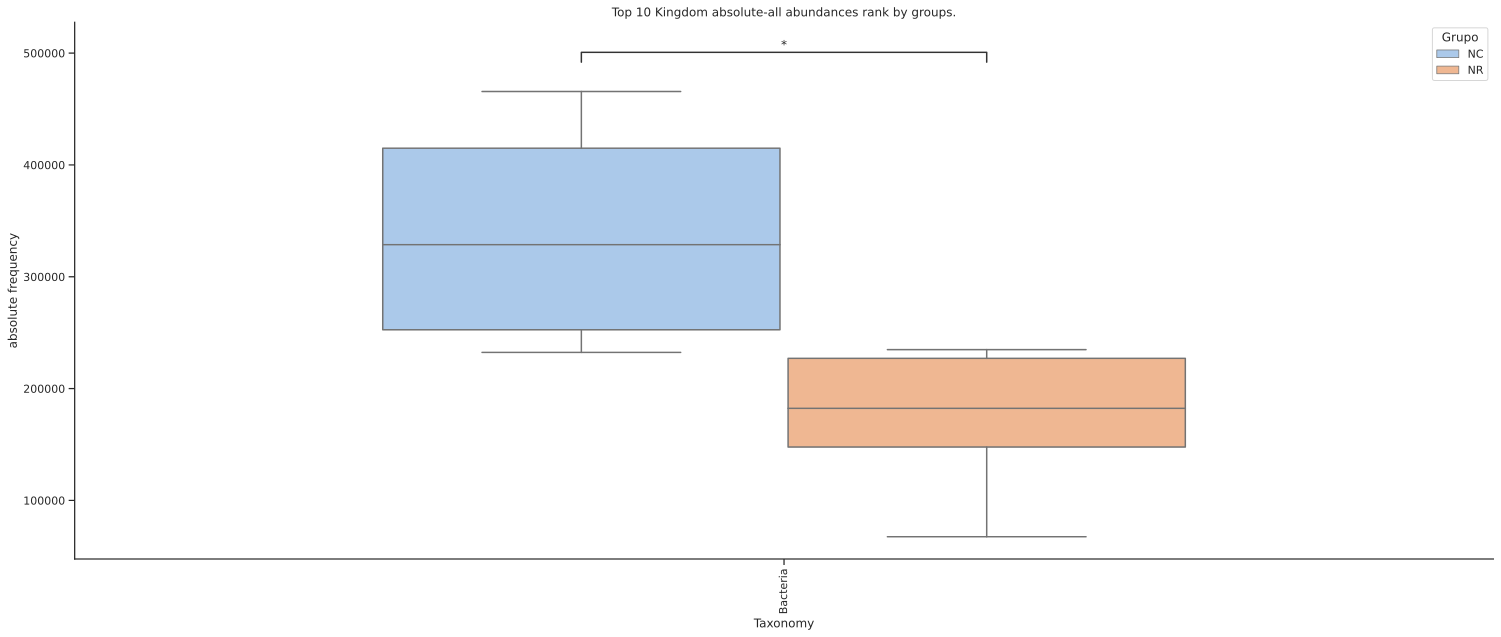

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Campilobacterota_NC v.s. Campilobacterota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.050e+01
Firmicutes_NC v.s. Firmicutes_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01
Bacteroidota_NC v.s. Bacteroidota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01


Verrucomicrobiota_NC v.s. Verrucomicrobiota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.887e-01 U_stat=1.700e+01
Proteobacteria_NC v.s. Proteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Actinobacteriota_NC v.s. Actinobacteriota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Cyanobacteria_NC v.s. Cyanobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Patescibacteria_NC v.s. Patescibacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Deferribacterota_NC v.s. Deferribacterota_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.302e-01 U_stat=1.700e+01
Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-all-abundance-Phylum-top-10.svg - using absolute-all frequencies


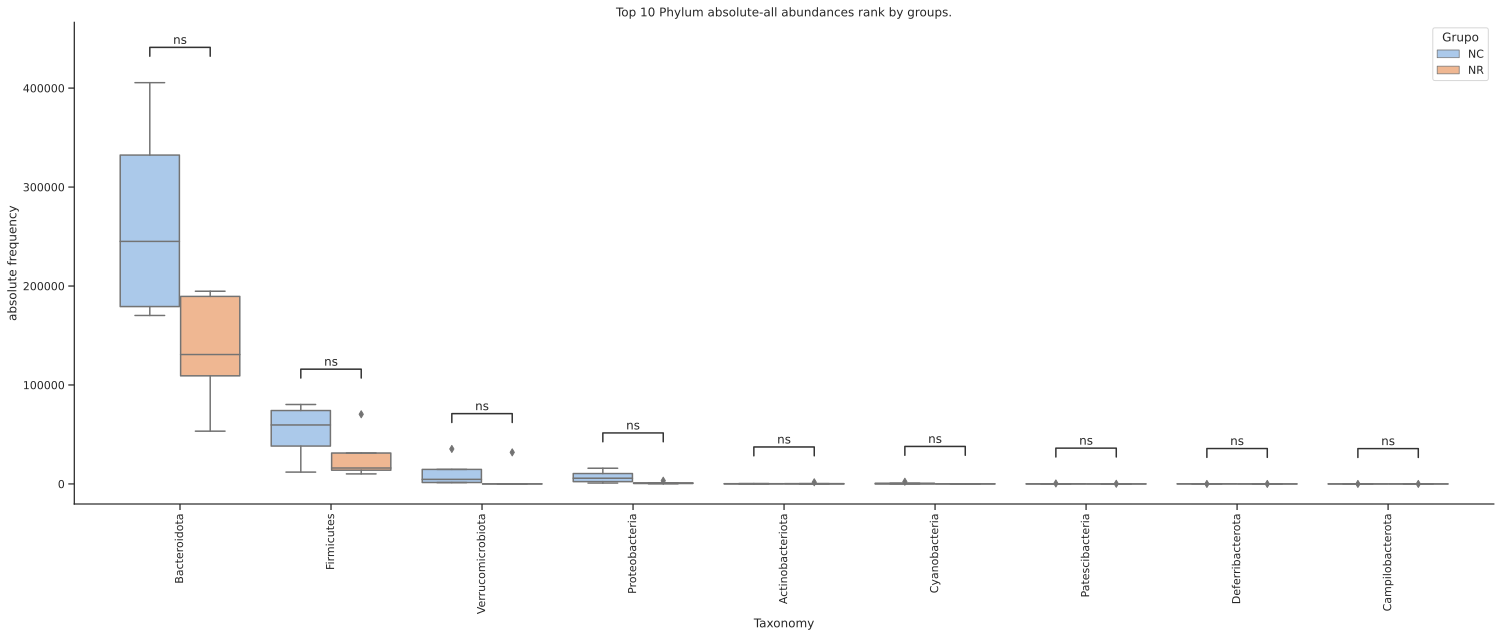

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Saccharimonadia_NC v.s. Saccharimonadia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Coriobacteriia_NC v.s. Coriobacteriia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Clostridia_NC v.s. Clostridia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Bacteroidia_NC v.s. Bacteroidia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
Bacilli_NC v.s. Bacilli_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Verrucomicrobiae_NC v.s. Verrucomicrobiae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Gammaproteobacteria_NC v.s. Gammaproteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01


Alphaproteobacteria_NC v.s. Alphaproteobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Vampirivibrionia_NC v.s. Vampirivibrionia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01
Actinobacteria_NC v.s. Actinobacteria_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.150e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-all-abundance-Class-top-10.svg - using absolute-all frequencies


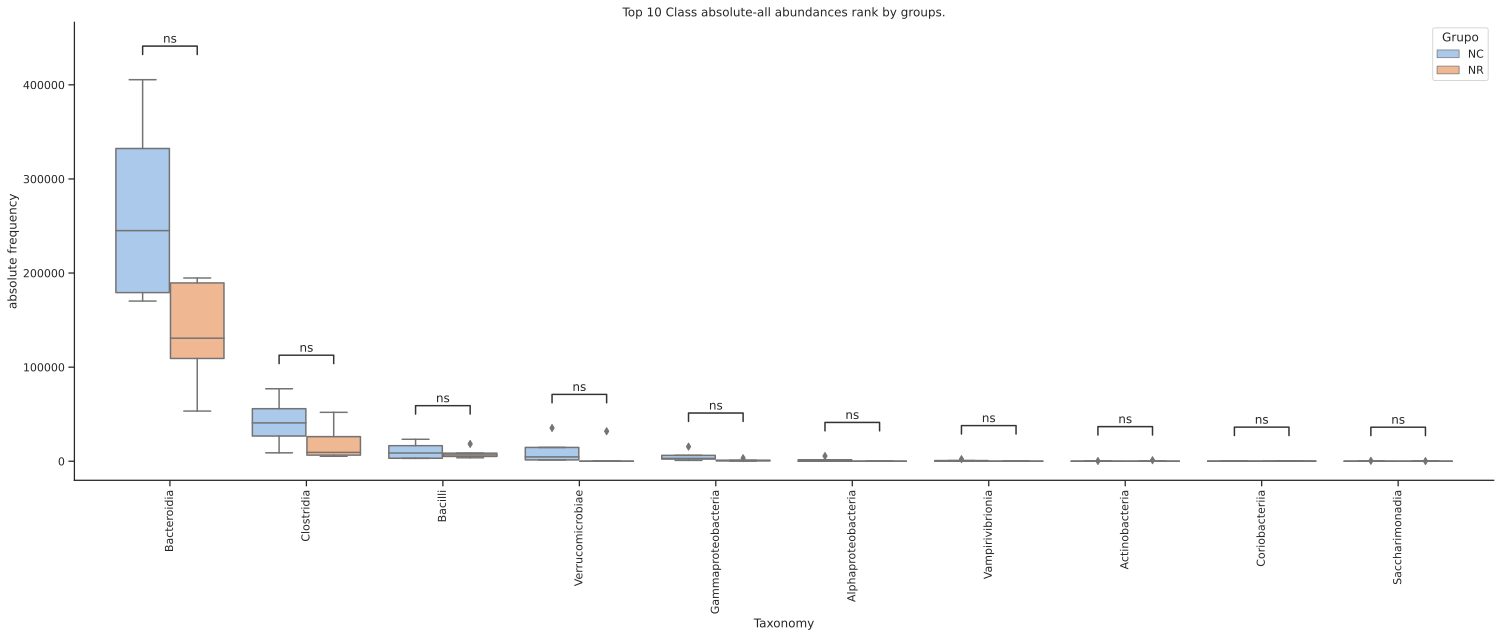

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Clostridia_UCG-014_NC v.s. Clostridia_UCG-014_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Erysipelotrichales_NC v.s. Erysipelotrichales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Lachnospirales_NC v.s. Lachnospirales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01


Bacteroidales_NC v.s. Bacteroidales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
Verrucomicrobiales_NC v.s. Verrucomicrobiales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Oscillospirales_NC v.s. Oscillospirales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Lactobacillales_NC v.s. Lactobacillales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01


Peptostreptococcales-Tissierellales_NC v.s. Peptostreptococcales-Tissierellales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Burkholderiales_NC v.s. Burkholderiales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-all-abundance-Order-top-10.svg - using absolute-all frequencies


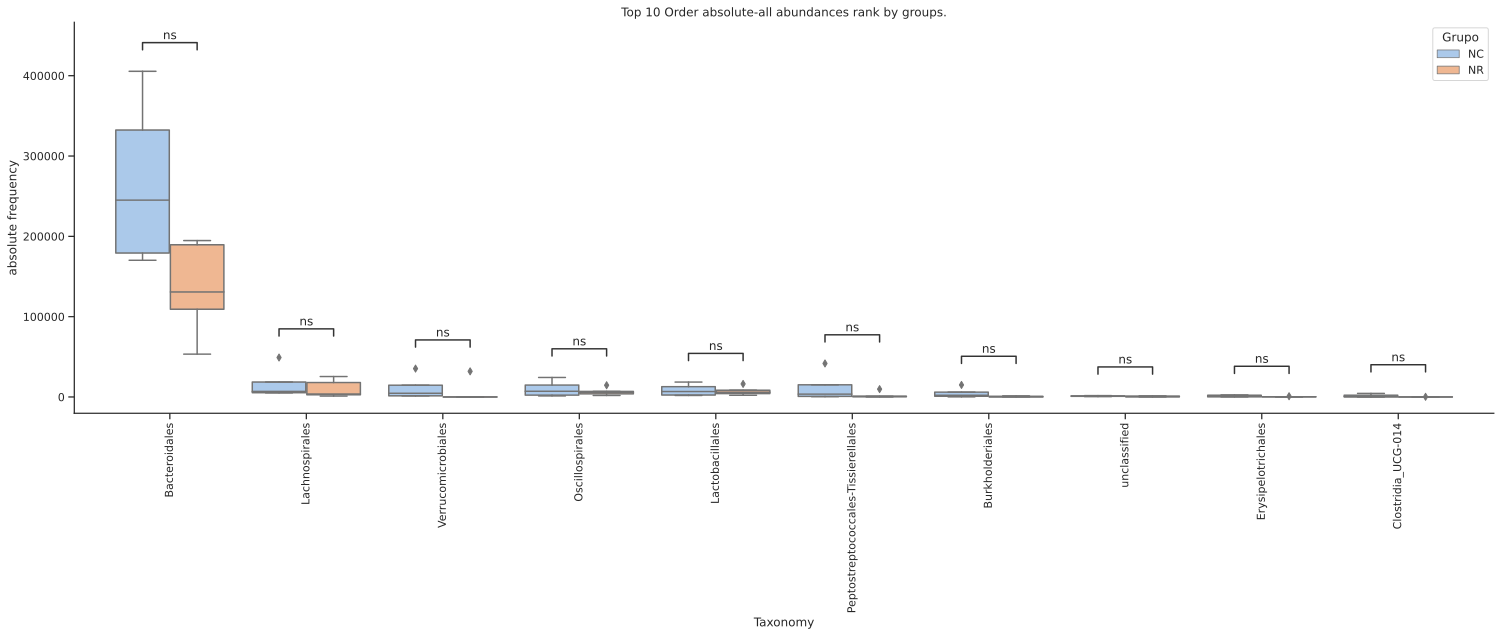

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Rikenellaceae_NC v.s. Rikenellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.550e+01
Oscillospiraceae_NC v.s. Oscillospiraceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Bacteroidaceae_NC v.s. Bacteroidaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01


Muribaculaceae_NC v.s. Muribaculaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Prevotellaceae_NC v.s. Prevotellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Lachnospiraceae_NC v.s. Lachnospiraceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Akkermansiaceae_NC v.s. Akkermansiaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01


Lactobacillaceae_NC v.s. Lactobacillaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Peptostreptococcaceae_NC v.s. Peptostreptococcaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
Tannerellaceae_NC v.s. Tannerellaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-all-abundance-Family-top-10.svg - using absolute-all frequencies


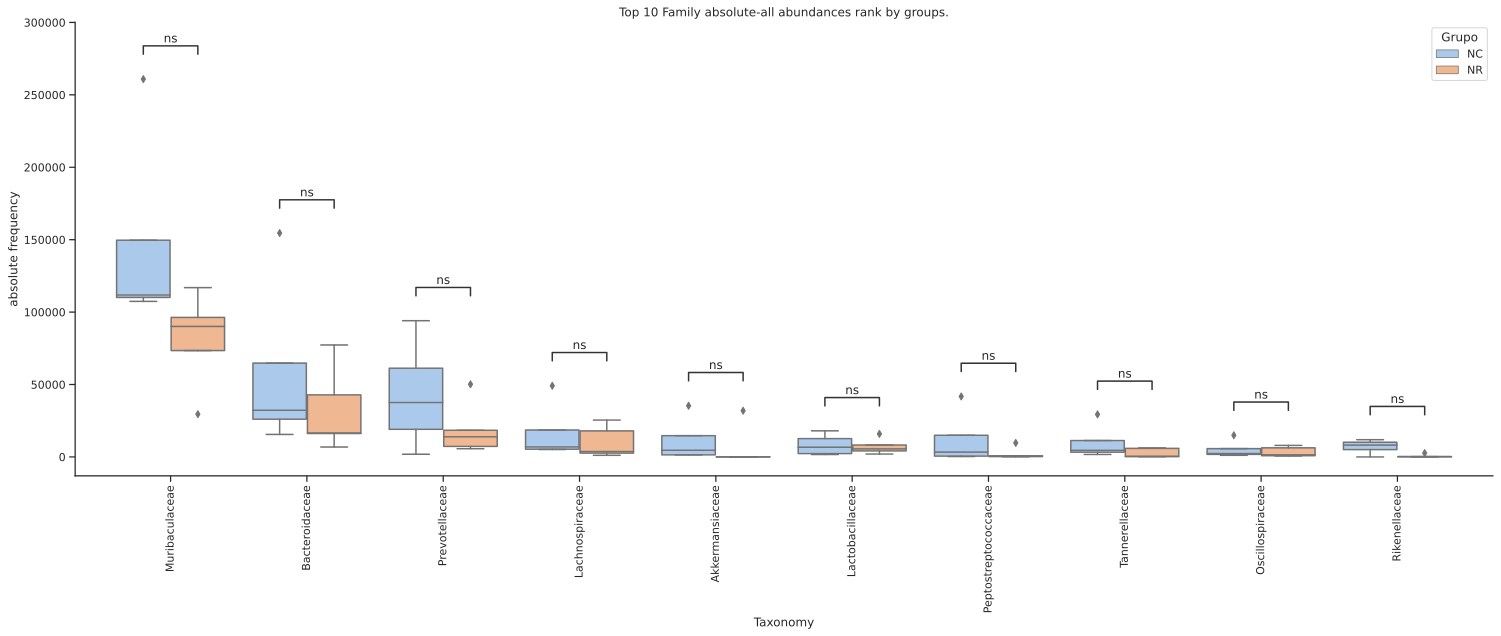

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Lachnospiraceae_NK4A136_group_NC v.s. Lachnospiraceae_NK4A136_group_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.000e+00
Parabacteroides_NC v.s. Parabacteroides_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Bacteroides_NC v.s. Bacteroides_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01


Muribaculaceae_NC v.s. Muribaculaceae_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Prevotellaceae_NK3B31_group_NC v.s. Prevotellaceae_NK3B31_group_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Prevotellaceae_UCG-001_NC v.s. Prevotellaceae_UCG-001_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Akkermansia_NC v.s. Akkermansia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01


unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01
Lactobacillus_NC v.s. Lactobacillus_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Romboutsia_NC v.s. Romboutsia_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-all-abundance-Genus-top-10.svg - using absolute-all frequencies


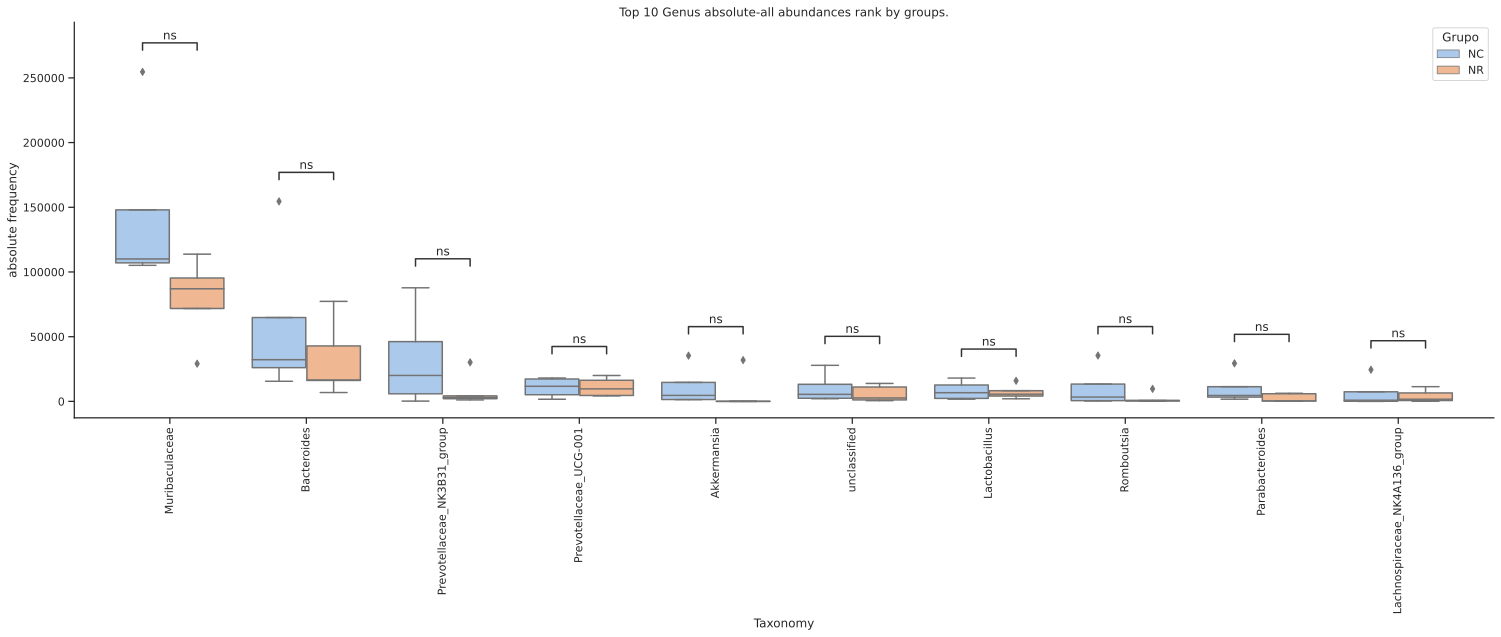

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Clostridium_sp._NC v.s. Clostridium_sp._NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.300e+01
gut_metagenome_NC v.s. gut_metagenome_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.250e+01
unclassified_NC v.s. unclassified_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.587e-01 U_stat=2.000e+01


uncultured_bacterium_NC v.s. uncultured_bacterium_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.700e+01
Bacteroides_fragilis_NC v.s. Bacteroides_fragilis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.000e+01
Bacteroides_caecimuris_NC v.s. Bacteroides_caecimuris_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.550e+01
Parabacteroides_goldsteinii_NC v.s. Parabacteroides_goldsteinii_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01


Lactobacillus_faecis_NC v.s. Lactobacillus_faecis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+00
uncultured_Bacteroidales_NC v.s. uncultured_Bacteroidales_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.400e+01
Lactobacillus_intestinalis_NC v.s. Lactobacillus_intestinalis_NR: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.200e+01


Saving boxplot with statistical significance to /home/lauro/nupeb/rede-micro/redemicro-ana-flavia-nutri/experiments/ana-flavia-NCxNR-trim/imgs/boxplot-absolute-all-abundance-Species-top-10.svg - using absolute-all frequencies


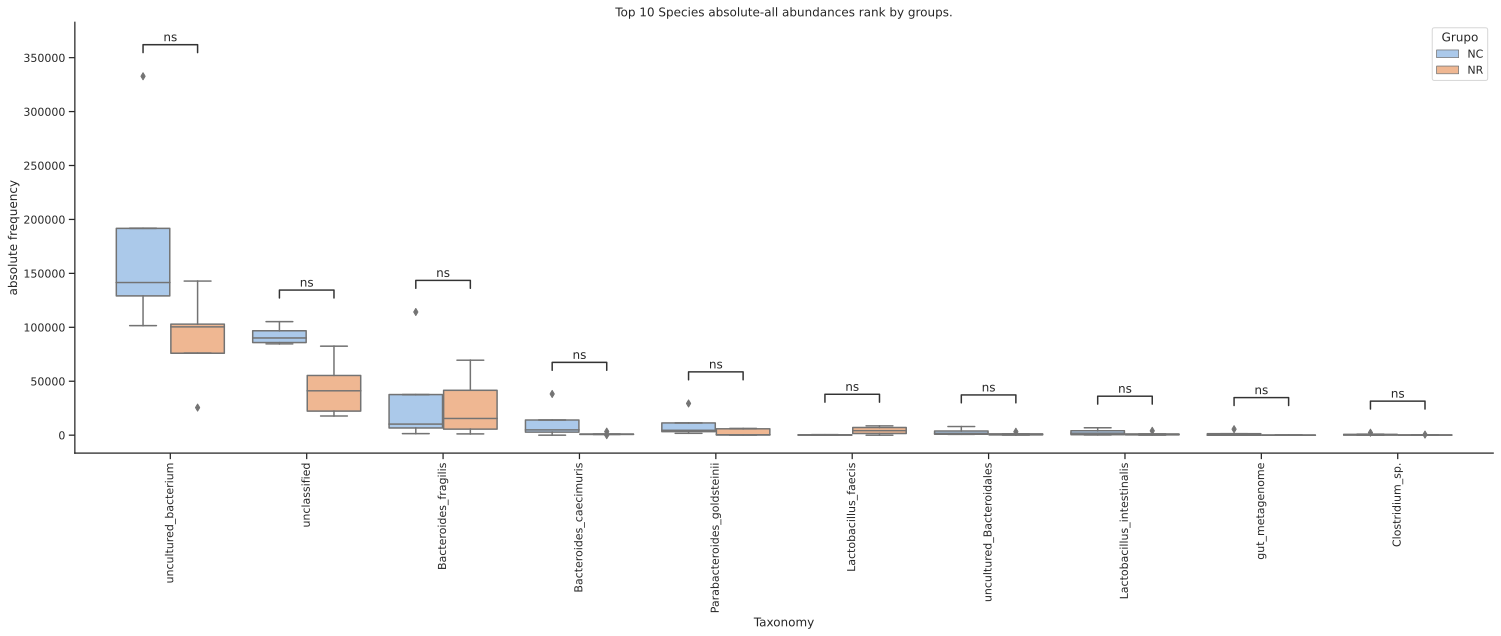

In [23]:
# DEFINE VARS
top_n = 10
group_label = 'Grupo'
do_plot = True

# ITERATE OVER FREQUENCIES (RELATIVE AND ABSOLUTE)
for tab_idx, levels_list in frequency_tables.items():
    # ITERATE OVER ALL TAX LEVELS (KINGDOM, PHYLUM, CLASS, ORDER, FAMILY, GENUS, SPECIES)
    for lvl, level_name in enumerate(tax_level):
        # SELECT LEVEL DATAFRAME
        df = levels_list[lvl].iloc[:top_n, 3:].T
        # CREATE GROUPED MELTED DF
        df[group_label] = 'NaN'
        for k, v in groups_keys.items():
            df.loc[v, group_label] = k
        df = df.melt(value_name='Abundance', var_name='Taxonomy', id_vars=group_label)

        if do_plot:

            # CREATE BOXPLOT STATS PAIRS
            box_pairs = list()
            taxons = df['Taxonomy'].unique()
            groups = df[group_label].unique()
            for t in taxons:
                tax_rows = list()
                for j in range(0, len(groups)):
                    for jj in range(j+1, len(groups)):
                        row = ((t, groups[j]), (t, groups[jj]))
                        tax_rows.append(row)
                box_pairs.extend(tax_rows)

            # PLOT BOXPLOTS
            plt.figure(figsize=(21,9), dpi=100)
            ax = sns.boxplot(x=df['Taxonomy'], y=df['Abundance'], hue=df[group_label])
            ax, test_results = add_stat_annotation(ax, data=df, x=df['Taxonomy'], y=df['Abundance'],
                                                   hue=df[group_label],
                                                   box_pairs=box_pairs,
                                                   test='Mann-Whitney',
                                                   loc='inside', verbose=2, #text_format='star',
                                                   )
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
            ax.set(ylabel=f'{tab_idx.split("-")[0]} frequency')
            plt.title(f'{f"Top {top_n} " if top_n is not None else ""}{level_name} {tab_idx} abundances rank by groups.')
            plt.tight_layout()
            sns.despine()

            # SAVE FIGURE
            path = os.path.abspath(os.path.join(img_folder, f'boxplot-{tab_idx}-abundance-{level_name}{f"-top-{top_n}" if top_n is not None else ""}.svg'))
            print(f'Saving boxplot with statistical significance to {path} - using {tab_idx} frequencies')
            plt.tight_layout()
            plt.savefig(path, format='svg')
            plt.show()